# Introduction
    FanDuel is a daily fantasy sports provider which hosts various competitions for it's members to compete in to win cash prizes.  The premise goes something like this:  Some sport (football in our case) will have a weekly slate of games, and FanDuel will offer a competition to assemble the best players for the week into a roster.  The roster will have two constraints - a salary cap, and positions constraints.  In football the position constraints are 1 QB, 2 RB, 3 WR, 1 TE, 1 Def, and 1 FLEX (which can be a RB/WR/TE.)  Naturally, the best players will cost the most so it's unwise to load up on these players because the rest of your roster will be very lacking.  The challenge to find the most return on investment when picking players.  You want to 1.) get most value for your picks, 2.) optimize your lineup so to not leave money on the table, and 3.) score as many points as possible.
# Objective
    For my analysis I chose football, and the competetition I chose to target is a global weekly competetion where any member can enter, but only the top 43.53% of entries win cash prizes - doubling money bet.  I created a model to predict points for players, and then used an optimizer to optimize lineups based on my predictions.  Due to the large variability in athletics, I have the optimizer returning about 70 entries to enter to see if my average placement can hover over the 43.53% placement rate to give me a positive return on investment.
# Techniques
    FanDuel Scraper:
        - Scraped FanDuel data from 2011-2018 to train my models
    NFL Player Stats data:
        - Downloaded from Kaggle.com
        - contained all gamelogs for all players from the inception of the NFL to midway through 2017
        - Scraped from profootballreference.com
    Wrangling:
        - Combined the FanDuel data with the NFL gamelog data for a large list of features per player per game
    Feature Engineering:
        - Split the data into seperate dataframes by position
            * Some features relevant to particular positions and not others
        - Created function to create map stats from previous games onto current datapoints
            * We won't have the current game stats when making our roster selections
        - Created a function to map a lagging average of important features
            * Tried Time-Series which didn't help with prediction, but the concept of a moving average proved to be a very important feature for my models
    Modeling:
        - A Gradient Boosting Regressor proved to be among the best performers while remaining very fast.  A random forest regressor had a similar performance but was much slower
        - The R^2 scores for QBs and RBs were around 50%, and the R^2 scores for WRs and TEs were around 40%.  Because the variance in sports is huge, these scores are acceptable.
        - With the models, I can get weekly predicted points for the players. 
    Optimizer:
        - A genetic algorithm was used to optimize the lineups
            * The constraints being salary cap and positional restraints, while trying to maximize total points predicted
        - The output from the genetic algorithm was 68 unique, optimized lineups
    Testing lineups:
        - The tournament we are targeting is "the NFL Single Entry Double Up (Thu-Mon)":
            * $25 or $10 or $5 entry fee
            * 100 or 68 or 20 entry maximum
            * The top 43.53% of entries will double up their money - doubling their money.
            
            
        
    
    



# FanDuel Scraper

In [39]:
import pandas as pd
import utils
import io
pd.options.display.max_columns=100
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import normalize

In [5]:
# library to generate user agent
from user_agent import generate_user_agent
# generate a user agent
headers = {'User-Agent': generate_user_agent(device_type="desktop", os=('mac', 'linux'))}
#headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.63 Safari/537.36'}

In [6]:
#http://rotoguru1.com/cgi-bin/fyday.pl?week=17&year=2011&game=fd&scsv=1
BASE_URL='http://rotoguru1.com/cgi-bin/fyday.pl?week=WEEK&year=YEAR&game=fd&scsv=1'
WEEKS=list(map(str,range(1,18)))
YEARS=list(map(str,range(2011,2018)))

In [7]:
#Code to scrape Draft Kings from 2014 to 2018:

FD_data=pd.DataFrame()
for yr in YEARS:
    print('FD Year:', yr)
    for wk in WEEKS:
        print('FD Week', wk)
        xxx=requests.get(BASE_URL.replace('WEEK',wk).replace('YEAR',yr))
        soup = BeautifulSoup(xxx.text, 'html.parser')
        FD_data=pd.concat([FD_data,pd.read_csv(io.StringIO(soup.find('pre').text),sep=';')])


FD Year: 2011
FD Week 1
FD Week 2
FD Week 3
FD Week 4
FD Week 5
FD Week 6
FD Week 7
FD Week 8
FD Week 9
FD Week 10
FD Week 11
FD Week 12
FD Week 13
FD Week 14
FD Week 15
FD Week 16
FD Week 17
FD Year: 2012
FD Week 1
FD Week 2
FD Week 3
FD Week 4
FD Week 5
FD Week 6
FD Week 7
FD Week 8
FD Week 9
FD Week 10
FD Week 11
FD Week 12
FD Week 13
FD Week 14
FD Week 15
FD Week 16
FD Week 17
FD Year: 2013
FD Week 1
FD Week 2
FD Week 3
FD Week 4
FD Week 5
FD Week 6
FD Week 7
FD Week 8
FD Week 9
FD Week 10
FD Week 11
FD Week 12
FD Week 13
FD Week 14
FD Week 15
FD Week 16
FD Week 17
FD Year: 2014
FD Week 1
FD Week 2
FD Week 3
FD Week 4
FD Week 5
FD Week 6
FD Week 7
FD Week 8
FD Week 9
FD Week 10
FD Week 11
FD Week 12
FD Week 13
FD Week 14
FD Week 15
FD Week 16
FD Week 17
FD Year: 2015
FD Week 1
FD Week 2
FD Week 3
FD Week 4
FD Week 5
FD Week 6
FD Week 7
FD Week 8
FD Week 9
FD Week 10
FD Week 11
FD Week 12
FD Week 13
FD Week 14
FD Week 15
FD Week 16
FD Week 17
FD Year: 2016
FD Week 1
FD Week 2
FD Wee

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,FD points,FD salary
0,1,2011,1131,"Brady, Tom",QB,nwe,a,mia,35.98,9200.0
1,1,2011,1309,"Henne, Chad",QB,mia,h,nwe,35.54,6800.0
2,1,2011,1378,"Newton, Cam",QB,car,a,ari,31.68,6700.0
3,1,2011,1151,"Brees, Drew",QB,nor,a,gnb,29.06,8900.0
4,1,2011,1242,"Fitzpatrick, Ryan",QB,buf,a,kan,24.62,7900.0
5,1,2011,1252,"Rodgers, Aaron",QB,gnb,h,nor,24.58,9800.0
6,1,2011,1340,"Stafford, Matthew",QB,det,a,tam,23.20,7300.0
7,1,2011,1155,"Vick, Michael",QB,phi,a,stl,23.18,9900.0
8,1,2011,1302,"Flacco, Joe",QB,bal,h,pit,20.96,7900.0
9,1,2011,1233,"Romo, Tony",QB,dal,a,nyj,19.58,8700.0


In [9]:
FD_data.to_csv(r'C:\Users\chase\Final_Capstone\Fantasy-FF\Player_data\FD_data.csv', sep=',')

# Marrying player data per gamelog to Fan Duel data

## Data was scraped from profootballreference.com by _______ but I downloaded the jsons from Kaggle

We can see a problem with the defenses.  There are 65 entries and 32 teams.  At some point the data entered changed from [city name Defense] to city name.  Also the San Diego Chargers relocated to LA, becoming the LA Chargers in our data, which accounts the the 65th team

In [1]:
import json
import pandas as pd
FD_data = pd.read_csv(r'C:\Users\chase\Final_Capstone\Fantasy-FF\Player_data\FD_data.csv')

In [2]:
#We also need to consider that St.Louis Rams relocated to LA, as did the San Diego Chargers
#Will set St.Louis Rams Defense equal to Los Angeles Defense, then set Los Angeles Defense to LA Rams
#Will set San Diego Chargers equal to LA Chargers
#Will delete all Defense terms
renamed=[]
for counter, name in enumerate(FD_data['Name']):
    if name == 'St. Louis Defense':
        renamed.append('LA Rams')
        continue
    if name == 'San Diego Defense':
        renamed.append('LA Chargers')
        continue
    if name == 'Los Angeles Defense':
        renamed.append('LA Rams')
        continue
    if 'Defense' in str(name):
        renamed.append(name.replace('Defense', '').strip())
    else:
        renamed.append(name)
FD_data['Name']=renamed

# Want to update the 'Name' column so the player names are 'firstname lastname'
names = []
for row in FD_data['Name']:
    a=[]
    if ',' in str(row):
        a.append(row)
        b=[]
        for i in a:
            b.append(i.split(','))
        for counter, i in enumerate(b):
             result = (b[counter][1].strip() + ' ' + b[counter][0])
        names.append(result)
    else:
        names.append(row)
FD_data['Name'] = names

# Code to save dataframes/scripts/etc. we want to preserve

In [3]:
import pickle
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Merging player info data (birthday, height, etc.) with FD_data

In [4]:
# Reading the json as a dict
with open(r'C:\Users\chase\Final_Capstone\Fantasy-FF\names\profiles_1512362725.022629.json') as json_data:
    data = json.load(json_data)
d = pd.DataFrame(data)

FD_data.Name = FD_data.Name.astype(str)
a = [x.strip().lower() for x in FD_data.Name]

FD_data.Name = a

b = [x.strip().lower() for x in d.name]
d.name = b

# fixing some of the nick names that were not consistent amongst both dataframes in the FD_data dataframe that join is on

mask = FD_data.Name == 'carnell williams'
column_name = 'Name'
FD_data.loc[mask, column_name] = 'cadillac williams'

mask = FD_data.Name == 'chad ochocinco'
column_name = 'Name'
FD_data.loc[mask, column_name] = 'chad johnson'

mask = FD_data.Name == 'ted ginn jr.'
column_name = 'Name'
FD_data.loc[mask, column_name] = 'ted ginn'

mask = FD_data.Name == 'joshua cribbs'
column_name = 'Name'
FD_data.loc[mask, column_name] = 'josh cribbs'


In [5]:
#merging on the FD_data Name columns to get the player_ids into the dataframe along with some other personal data
all_data = pd.merge(FD_data, d, how='left', left_on="Name", right_on="name")

# dropping rookie players that I don't have data on and defense through the position column which isnull()
all_data = pd.concat([all_data, all_data[all_data.position.isnull() == True]]).drop_duplicates(keep=False)

#offensive positions to keep in the dataframe.  Other positions are non-offensive and thus not relevant.
positions = ['WR', 'RB', 'QB', 'TE', 'K', 'FB', 'TE-FB', 'PR-WR', 'FB-RB-TB-TE', 'TE-C', 'WR/RB', 'FB-LB', 'TE-WR', 'RB-TE', '']

#dropping positions from dataframe not in positions list
all_data = all_data[all_data.position.isin(positions)]

#getting the index value (for .iloc) of the players with multiple birth dates... so players with the same name that I will
#need to sort out.  Using this as a workaround --- probably an easier way to pull out these players
multiple = []
for counter, n in enumerate(all_data.groupby(['Name'])['birth_date'].unique()):
    if len(n) > 1:
        multiple.append(counter)

multiple_names = []
for counter, x in enumerate(sorted(all_data['Name'].unique())):
    for i in multiple:
        if counter ==i:
            multiple_names.append(x)

multiple_names

['adrian peterson',
 'alex smith',
 'andre brown',
 'anthony allen',
 'antonio brown',
 'brandon williams',
 'charles johnson',
 'chris givens',
 'chris harper',
 'david johnson',
 'david nelson',
 'dennis johnson',
 'george farmer',
 'greg jones',
 'henry hynoski',
 'james jones',
 'james wright',
 'kellen winslow',
 'kevin smith',
 'malcolm johnson',
 'mark clayton',
 'mark ingram',
 'matt jones',
 'michael smith',
 'michael williams',
 'mickey shuler',
 'mike thomas',
 'mike williams',
 'paul richardson',
 'ricky williams',
 'robert woods',
 'rod smith',
 'ryan grant',
 'steve johnson',
 'steve smith',
 'zach miller']

In [6]:
test = all_data

# code to drop players w same name that WE DONT NEED... Dropping based on another indicator, in this case college
test = test.drop(test[test['Name'] == 'adrian peterson'][test.college == 'Georgia Southern'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'alex smith'
mask2 = test.college == 'Utah'
mask3 = test.Pos == 'TE'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'alex smith'
mask2 = test.college == 'Stanford'
mask3 = test.Pos == 'QB'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

# code to drop players w same name that WE DONT NEED... Dropping based on another indicator, in this case college
test = test.drop(test[test['Name'] == 'andre brown'][test.college == 'Miami (FL)'].index)

# code to drop players w same name that WE DONT NEED... Dropping based on another indicator, in this case college
test = test.drop(test[test['Name'] == 'anthony allen'][test.college == 'Washington'].index)

# code to drop players w same name that WE DONT NEED... Dropping based on another indicator, in this case college
test = test.drop(test[test['Name'] == 'antonio brown'][test.college == 'West Virginia'].index)

test = test.drop(test[test['Name'] == 'brandon williams'][test.college == 'Wisconsin'].index)

test = test.drop(test[test['Name'] == 'charles johnson'][test.college == 'Colorado'].index)

test = test.drop(test[test['Name'] == 'chris givens'][test.college == 'Miami (OH)'].index)

#dropping chris harper... two wide receivers who barely played but played around the same time.. will just drop
test = test.drop(test[test['Name'] == 'chris harper'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'david johnson'
mask2 = test.college == 'Northern Iowa'
mask3 = test.Pos == 'TE'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'david johnson'
mask2 = test.college == 'Arkansas St.'
mask3 = test.Pos == 'RB'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

test = test.drop(test[test['Name'] == 'david nelson'][test.college == 'Heidelberg'].index)

test = test.drop(test[test['Name'] == 'dennis johnson'][test.college == 'Mississippi St.'].index)

test = test.drop(test[test['Name'] == 'george farmer'][test.college == 'Southern'].index)
test = test.drop(test[test['Name'] == 'george farmer'][test.college == 'UCLA'].index)

test = test.drop(test[test['Name'] == 'greg jones'][test.college == 'UCLA'].index)

test = test.drop(test[test['Name'] == 'henry hynoski'][test.college == 'Temple'].index)

test = test.drop(test[test['Name'] == 'james jones'][test.college == 'Mississippi St.'].index)
test = test.drop(test[test['Name'] == 'james jones'][test.college == 'Florida'].index)

test = test.drop(test[test['Name'] == 'james wright'][test.college == 'TCU'].index)

test = test.drop(test[test['Name'] == 'kellen winslow'][test.college == 'Missouri'].index)

test = test.drop(test[test['Name'] == 'kevin smith'][test.college == 'UCLA'].index)

test = test.drop(test[test['Name'] == 'kevin smith'][test.college == 'Washington'].index)

test = test.drop(test[test['Name'] == 'malcolm johnson'][test.college == 'Notre Dame'].index)

test = test.drop(test[test['Name'] == 'mark clayton'][test.college == 'Louisville'].index)

test = test.drop(test[test['Name'] == 'mark ingram'][test.college == 'Michigan St.'].index)

test = test.drop(test[test['Name'] == 'matt jones'][test.college == 'Arkansas'].index)

test = test.drop(test[test['Name'] == 'michael smith'][test.college == 'Kansas St.'].index)

test = test.drop(test[test['Name'] == 'mickey shuler'][test.birth_place == 'Harrisburg, PA'].index)

test = test.drop(test[test['Name'] == 'mike thomas'][test.college == 'Oklahoma'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'mike thomas'
mask2 = test.college == 'Southern Miss'
mask3 = test.Team == 'jac'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike thomas'
mask2 = test.college == 'Southern Miss'
mask3 = test.Team == 'det'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike thomas'
mask2 = test.college == 'Arizona'
mask3 = test.Pos == 'lar'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

test = test.drop(test[test['Name'] == 'mike williams'][test.college == 'Alabama A&M;'].index)
test = test.drop(test[test['Name'] == 'mike williams'][test.college == 'Northeastern'].index)
test = test.drop(test[test['Name'] == 'mike williams'][test.birth_place == 'New Kingston, PA'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'mike williams'
mask2 = test.college == 'Clemson'
mask3 = test.Team == 'tam'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'Clemson'
mask3 = test.Team == 'sea'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'Clemson'
mask3 = test.Team == 'buf'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'Syracuse'
mask3 = test.Pos == 'lac'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'Syracuse'
mask3 = test.Pos == 'sea'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'USC'
mask3 = test.Pos == 'lac'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'USC'
mask3 = test.Pos == 'tam'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'mike williams'
mask2 = test.college == 'USC'
mask3 = test.Pos == 'buf'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

test = test.drop(test[test['Name'] == 'paul richardson'][test.college == 'UCLA'].index)

test = test.drop(test[test['Name'] == 'ricky williams'][test.college == 'Texas Tech'].index)
test = test.drop(test[test['Name'] == 'ricky williams'][test.college == 'Langston'].index)

test = test.drop(test[test['Name'] == 'robert woods'][test.college == 'Grambling St.'].index)

test = test.drop(test[test['Name'] == 'rod smith'][test.college == 'Missouri Southern'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'ryan grant'
mask2 = test.college == 'Tulane'
mask3 = test.Pos == 'RB'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'ryan grant'
mask2 = test.college == 'Notre Dame'
mask3 = test.Pos == 'WR'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

test = test.drop(test[test['Name'] == 'steve johnson'][test.college == 'Virginia Tech'].index)

test = test.drop(test[test['Name'] == 'steve smith'][test.college == 'Penn St.'].index)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'steve smith'
mask2 = test.college == 'Utah'
mask3 = test.Team == 'phi'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'steve smith'
mask2 = test.college == 'Utah'
mask3 = test.Team == 'stl'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'steve smith'
mask2 = test.college == 'USC'
mask3 = test.Team == 'car'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'steve smith'
mask2 = test.college == 'USC'
mask3 = test.Team == 'bal'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'zach miller'
mask2 = test.college == 'Arizona St.'
mask3 = test.Team == 'chi'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

#dropping the wrong duplicate alex smiths
mask1 = test.Name == 'zach miller'
mask2 = test.college == 'Arizona St.'
mask3 = test.Team == 'jac'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

mask1 = test.Name == 'zach miller'
mask2 = test.college == 'Nebraska-Omaha'
mask3 = test.Team == 'sea'
test = pd.concat([test, test[(mask1) & (mask2) & (mask3)]]).drop_duplicates(keep=False)

all_data = test

C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean S

In [7]:
#getting the index value (for .iloc) of the players with multiple birth dates... so players with the same name that I will
#need to sort out.  Using this as a workaround --- probably an easier way to pull out these players
multiple = []
for counter, n in enumerate(all_data.groupby(['Name'])['birth_date'].unique()):
    if len(n) > 1:
        multiple.append(counter)

multiple_names = []
for counter, x in enumerate(sorted(all_data['Name'].unique())):
    for i in multiple:
        if counter ==i:
            multiple_names.append(x)

multiple_names

['alex smith',
 'david johnson',
 'michael williams',
 'mike thomas',
 'mike williams',
 'ryan grant',
 'steve smith',
 'zach miller']

# Importing Stats dataset; engineering it and merging it to all_data to create a master dataframe

In [8]:
# Reading the json as a dict
with open(r'C:\Users\chase\Final_Capstone\Fantasy-FF\player_stats\games_1512362753.8735218.json') as json_data:
    data = json.load(json_data)
stats = pd.DataFrame(data)


In [9]:
#Creating a new by_team dataframe for:
#Creating an isolated dataframe only containing team, year, and date so
#we can create a Week column based on the dates for each team and when they played

from datetime import datetime
by_team = stats.loc[:, ['team','year','date']]
by_team = by_team.sort_values(by=(['team', 'year', 'date']))
by_team = by_team.drop_duplicates()
by_team['date_time'] = [datetime.strptime(x, '%Y-%m-%d') for x in by_team.date]

#Creating lists of TEAMS and YEARS.
#Then iterating over both, and creating a list of date_time for each team given the year
#the running a loop over the list; and subtracting the dates from each other to get a day difference column
#We need this column for our next bit of code which is assigning the weeks # for each game

TEAMS = sorted(list(by_team.team.unique()))
YEARS = sorted(list(by_team.year.unique()))
datediff=[]
for tm in TEAMS:
    print('Team:', tm)
    for yr in YEARS:
        print('     Year:', yr)
        time = list(by_team.date_time[(by_team.team == tm) & (by_team.year == yr)])
        for counter, (i, j) in enumerate(zip(time[: -1], time[1 :])):
            if counter == 0:
                datediff.append(0)
            datediff.append((j - i).days)
by_team['datediff'] = datediff

#using the dateddiff from above:
#any games that have a difference of greater than ten games, means there is a buy week between them
#this is important when assigning the Week # a game is in -- can't just assign a range
#but need to skip the week where there is a buy
#so when the difference between game dates is greater than 10

Week = []
counter = 0
for x in by_team.datediff:
    if x == 0:
        counter = 0
    if x > 10:
        counter += 1
    counter += 1
    Week.append(counter)
by_team['Week'] = Week

#merging our by_team dataframe with stats
#then merging our new WEEK_merg dataframe with all_stats

WEEK_merge = pd.merge(stats, by_team, how='left', left_on=["team", 'year', 'date'], right_on=["team", 'year', 'date'])
master = pd.merge(all_data, WEEK_merge, how='left', left_on=["player_id", 'Year', 'Week'], right_on=["player_id", 'year', 'Week'])

#Saving the master dataframe

save_obj(master, 'master_after_merge')

Team: ARI
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 1957
     Year: 1958
     Year: 1959
     Year: 1960
     Year: 1961
     Year: 1962
     Year: 1963
     Year: 1964
     Year: 1965
     Year: 1966
     Year: 1967
     Year: 1968
     Year: 1969
     Year: 1970
     Year: 1971
     Year: 1972
     Year: 1973
     Year: 1974
     Year: 1975
     Year: 1976
     Year: 1977
     Year: 1978
     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 1990
     Year: 1991
     Year: 1992
     Year: 1993
     Year: 1994
     Year: 1995
     Year: 1996
     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 201

     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 2011
     Year: 2012
     Year: 2013
     Year: 2014
     Year: 2015
     Year: 2016
     Year: 2017
Team: CLE
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 1957
     Year: 1958
     Year: 1959
     Year: 1960
     Year: 1961
     Year: 1962
     Year: 1963
     Year: 1964
     Year: 1965
     Year: 1966
     Year: 1967
     Year: 1968
     Year: 1969
     Year: 1970
     Year: 1971
     Year: 1972
     Year: 1973
     Year: 1974
     Year: 1975
     Year: 1976
     Year: 1977
     Year: 1978
     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 199

     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 1990
     Year: 1991
     Year: 1992
     Year: 1993
     Year: 1994
     Year: 1995
     Year: 1996
     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 2011
     Year: 2012
     Year: 2013
     Year: 2014
     Year: 2015
     Year: 2016
     Year: 2017
Team: IND
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 1957
     Year: 1958
     Year: 1959
     Year: 1960
     Year: 1961
     Year: 1962
     Year: 1963
     Year: 1964
     Year: 1965
     Year: 1966
     Year: 1967
     Year: 1968
     Year: 1969
     Year: 1970
     Year: 1971
     Year: 197

     Year: 1964
     Year: 1965
     Year: 1966
     Year: 1967
     Year: 1968
     Year: 1969
     Year: 1970
     Year: 1971
     Year: 1972
     Year: 1973
     Year: 1974
     Year: 1975
     Year: 1976
     Year: 1977
     Year: 1978
     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 1990
     Year: 1991
     Year: 1992
     Year: 1993
     Year: 1994
     Year: 1995
     Year: 1996
     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 2011
     Year: 2012
     Year: 2013
     Year: 2014
     Year: 2015
     Year: 2016
     Year: 2017
Team: NWE
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 195

     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 2011
     Year: 2012
     Year: 2013
     Year: 2014
     Year: 2015
     Year: 2016
     Year: 2017
Team: PHO
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 1957
     Year: 1958
     Year: 1959
     Year: 1960
     Year: 1961
     Year: 1962
     Year: 1963
     Year: 1964
     Year: 1965
     Year: 1966
     Year: 1967
     Year: 1968
     Year: 1969
     Year: 1970
     Year: 1971
     Year: 1972
     Year: 1973
     Year: 1974
     Year: 1975
     Year: 1976
     Year: 1977
     Year: 1978
     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 199

     Year: 1970
     Year: 1971
     Year: 1972
     Year: 1973
     Year: 1974
     Year: 1975
     Year: 1976
     Year: 1977
     Year: 1978
     Year: 1979
     Year: 1980
     Year: 1981
     Year: 1982
     Year: 1983
     Year: 1984
     Year: 1985
     Year: 1986
     Year: 1987
     Year: 1988
     Year: 1989
     Year: 1990
     Year: 1991
     Year: 1992
     Year: 1993
     Year: 1994
     Year: 1995
     Year: 1996
     Year: 1997
     Year: 1998
     Year: 1999
     Year: 2000
     Year: 2001
     Year: 2002
     Year: 2003
     Year: 2004
     Year: 2005
     Year: 2006
     Year: 2007
     Year: 2008
     Year: 2009
     Year: 2010
     Year: 2011
     Year: 2012
     Year: 2013
     Year: 2014
     Year: 2015
     Year: 2016
     Year: 2017
Team: TAM
     Year: 1950
     Year: 1951
     Year: 1952
     Year: 1953
     Year: 1954
     Year: 1955
     Year: 1956
     Year: 1957
     Year: 1958
     Year: 1959
     Year: 1960
     Year: 1961
     Year: 1962
     Year: 196

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

# Now evaluating and cleaning up nulls # STARTING FROM HERE

In [ ]:
import pickle
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [19]:
master = load_obj('master_after_merge')

In [20]:
afterdrop = master.drop(columns=(['birth_place', 'birth_date', 'college', 'current_salary', 'current_team', 'death_date', 'draft_position',
                     'draft_team', 'draft_year', 'height', 'high_school', 'hof_induction_year', 'weight']))
afterdrop.draft_round = afterdrop.draft_round.fillna('Undrafted')

null_df=pd.DataFrame(columns=(['column', 'null_num', 'null%']))
null_df.column=list(afterdrop.columns)
null_df.null_num = list(afterdrop.isnull().sum())
null_df['null%'] = list((afterdrop.isnull().sum())/afterdrop.shape[0])
null_df=null_df.sort_values(by=['null%'], ascending=False)

null_df

,column,null_num,null%
33,opponent_score,2999,0.064275
34,passing_attempts,2999,0.064275
36,passing_interceptions,2999,0.064275
37,passing_rating,2999,0.064275
38,passing_sacks,2999,0.064275
39,passing_sacks_yards_lost,2999,0.064275
40,passing_touchdowns,2999,0.064275
41,passing_yards,2999,0.064275
42,player_team_score,2999,0.064275
43,point_after_attemps,2999,0.064275


In [21]:
master = afterdrop.dropna()
master.rename(columns={'passing_attempts':'passing_completions', 'passing_completions':'passing_attempts'}, inplace=True)
master.drop(columns=(['player_num', 'day', 'daydifference', 'datetime', 'datediff']), inplace=True)
master.drop(master.loc[:, 'defense_interception_touchdowns':'defense_tackles'].columns, axis = 1, inplace=True) 
master.drop(columns=(['name', 'team', 'year']), inplace=True)
master.drop(columns=(['game_number', 'punting_blocked']), inplace=True)

C:\Users\chase\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\chase\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
#chaning team abbreviations to the new abbreviation (because team relocated)
master.loc[master['Oppt'] == 'stl', 'Oppt'] = 'lar'
master.loc[master['Oppt'] == 'sdg', 'Oppt'] = 'lac'
master.loc[master['Team'] == 'stl', 'Team'] = 'lar'
master.loc[master['Team'] == 'sdg', 'Team'] = 'lac'

C:\Users\chase\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<Figure size 640x480 with 0 Axes>

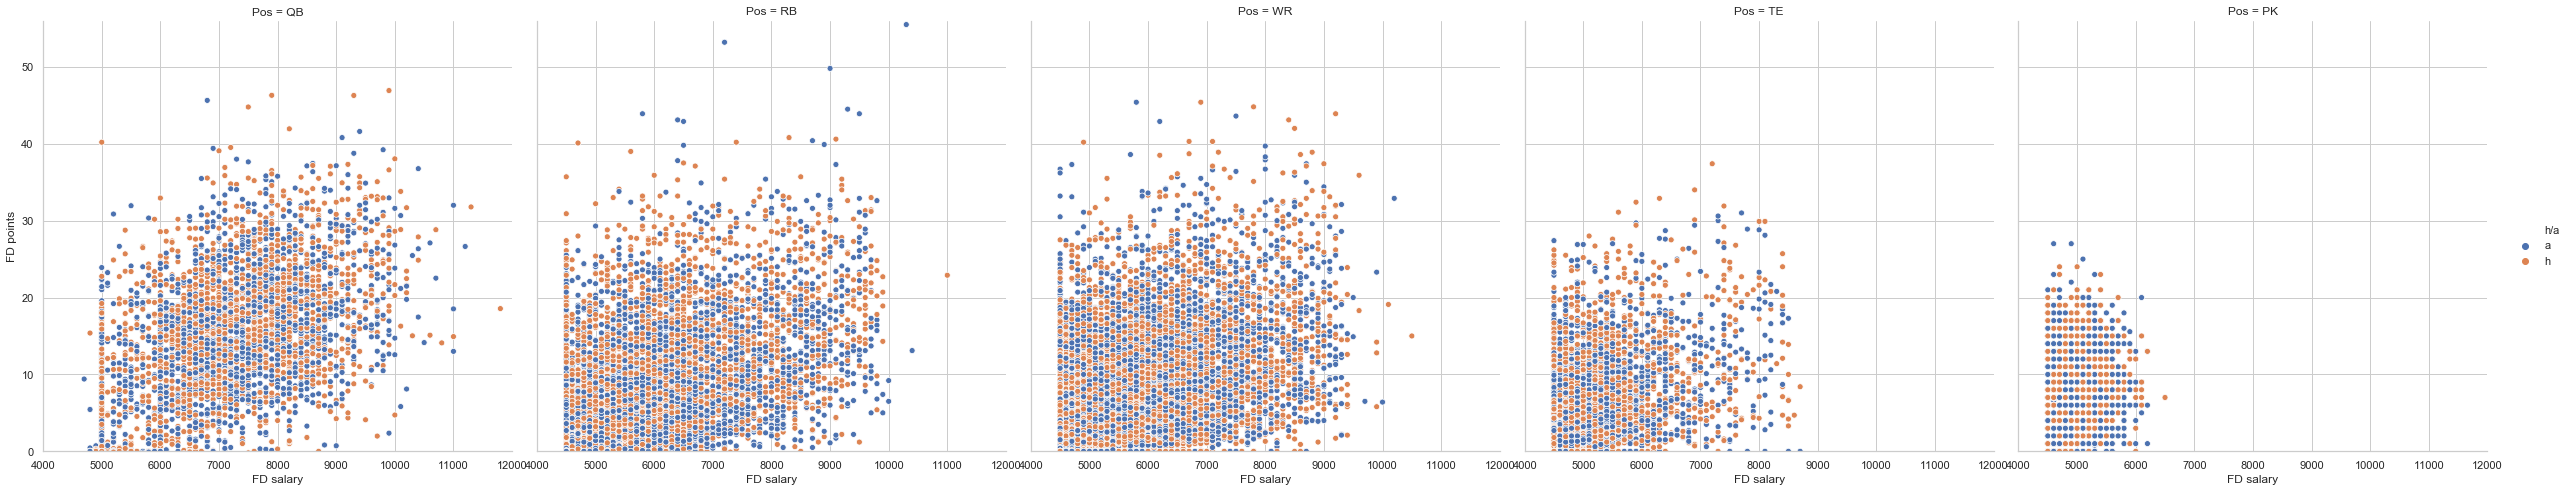

In [23]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.set(style='whitegrid')
g = sns.relplot(x="FD salary", y="FD points", col="Pos",
            hue="h/a", height=7, 
            data=master)
g.set(ylim=(0, 56))
g.set(xlim=(4000, 12000))

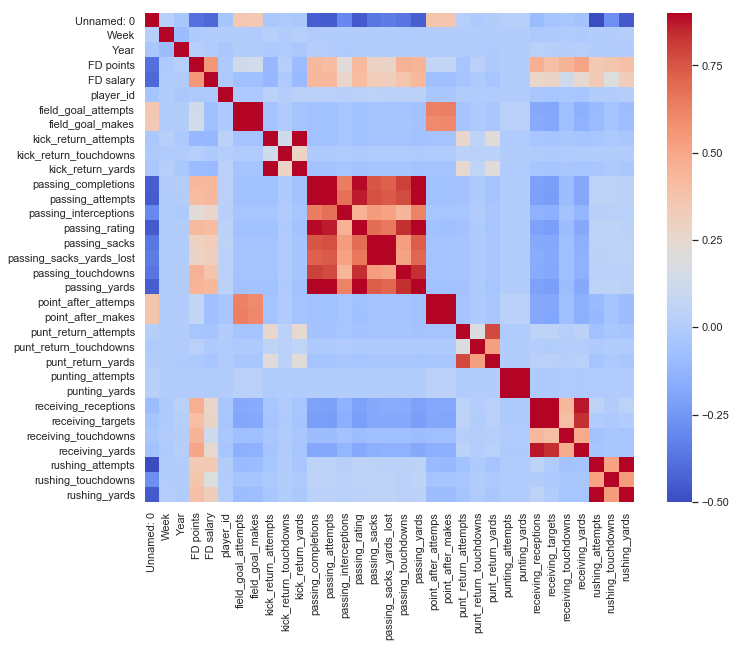

In [28]:
f, ax = plt.subplots(figsize=(12, 9))
x = sns.heatmap(master.corr(), cmap='coolwarm', square=True, vmax=.9)

In [741]:
master.sort_values(by=(['player_id', 'Year', 'Week']), inplace=True)

C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [742]:
#### USEFUL FEATURE ENGINEERING FUNCTIONS#####

#function to get the previous game's stats on the same row as FD salary, FD points for prediction purposes because we
#will not have those stats available before the game starts; Will not consider year like functions above
def previous_game_var_mapper(DF, feature):
    TEAMS=sorted(list(DF['Team'].unique()))
    PLAYER_ID=sorted(list(DF['player_id'].unique()))
    a=[]
    for plr in PLAYER_ID:
            df = DF[(DF.player_id == plr)]
            x = sorted(list(df.date_time))
            for counter, x in enumerate(x):
                if counter == 0:            
                    result = 'None'
                else:
                    result = DF[feature].iloc[counter - 1]
                a.append(result)
    DF[feature + '_prev_week'] = a 
    return DF[feature + '_prev_week']

def previous_2_game_var_mapper(DF, feature):
    TEAMS=sorted(list(DF['Team'].unique()))
    PLAYER_ID=sorted(list(DF['player_id'].unique()))
    a=[]
    for plr in PLAYER_ID:
            df = DF[(DF.player_id == plr)]
            x = sorted(list(df.date_time))
            for counter, x in enumerate(x):
                if counter == 0:                    ###Need to re-evaulate master[col_of_interest][counter], counter resets
                    result = 'None'
                if counter == 1:
                    result == 'None'
                if counter > 1:
                    result = df[feature].iloc[counter-2]
                a.append(result)
    DF[feature + '_prev_2_week'] = a 
    return DF[feature + '_prev_2_week']

def previous_3_game_var_mapper(DF, feature):
    TEAMS=sorted(list(DF['Team'].unique()))
    PLAYER_ID=sorted(list(DF['player_id'].unique()))
    a=[]
    for plr in PLAYER_ID:
            df = DF[(DF.player_id == plr)]
            x = sorted(list(df.date_time))
            for counter, x in enumerate(x):
                if counter == 0:                    ###Need to re-evaulate master[col_of_interest][counter], counter resets
                    result = 'None'
                if counter == 1:
                    result == 'None'
                if counter == 2:
                    result == 'None'
                if counter > 2:
                    result = df[feature].iloc[counter-3]
                a.append(result)
    DF[feature + '_prev_3_week'] = a 
    return DF[feature + '_prev_3_week']

def previous_4_game_var_mapper(DF, feature):
    TEAMS=sorted(list(DF['Team'].unique()))
    PLAYER_ID=sorted(list(DF['player_id'].unique()))
    a=[]
    for plr in PLAYER_ID:
            df = DF[(DF.player_id == plr)]
            x = sorted(list(df.date_time))
            for counter, x in enumerate(x):
                if counter == 0:                    ###Need to re-evaulate master[col_of_interest][counter], counter resets
                    result = 'None'
                if counter == 1:
                    result == 'None'
                if counter == 2:
                    result == 'None'
                if counter == 3:
                    result == 'None'
                if counter > 3:
                    result = df[feature].iloc[counter-4]
                a.append(result)
    DF[feature + '_prev_4_week'] = a 
    return DF[feature + '_prev_4_week']

# A trailing 4-game average that can be used for numerical features

def prev_4_game_average(DF, feature):
    TEAMS=sorted(list(DF['Team'].unique()))
    PLAYER_ID=sorted(list(DF['player_id'].unique()))
    a=[]
    for plr in PLAYER_ID:
            df = DF[(DF.player_id == plr)]
            x = sorted(list(df.date_time))
            for counter, x in enumerate(x):
                if counter == 0:                    ###Need to re-evaulate master[col_of_interest][counter], counter resets
                    result = df[feature].iloc[0]
                if counter == 1:
                    result = df[feature].iloc[0:2].mean()
                if counter == 2:
                    result = df[feature].iloc[0:3].mean()
                if counter == 3:
                    result = df[feature].iloc[0:4].mean()
                if counter >3:
                    result = df[feature].iloc[(counter-4):(counter)].mean()
                a.append(result)
    DF[feature + '_prev_4_game_average'] = a 
    return DF[feature + '_prev_4_game_average']

#One hot encoding for categorical variables
#creating function for one-hot encoding of relevant categorical variables
def One_hot_encoder(DF, feature_list):
    for x in feature_list:
        a=pd.get_dummies(DF[x])
        DF=pd.concat([DF, a], axis=1)
    return DF

In [743]:
#creating dataframes by position:
WR = master[master.Pos == 'WR']
RB = master[master.Pos == 'RB']
PK = master[master.Pos == 'PK']
QB = master[master.Pos == 'QB']
TE = master[master.Pos == 'TE']

#Saving the datframes before altering them too much
save_obj(WR, 'WR_DF')
save_obj(RB, 'RB_DF')
save_obj(PK, 'PK_DF')
save_obj(QB, 'QB_DF')
save_obj(TE, 'TE_DF')

In [744]:
#creating a Defense dataframe - only feature is trailing 4-game FD points average
FD_data = pd.read_csv(r'C:\Users\chase\Final_Capstone\Fantasy-FF\Player_data\FD_data.csv')
renamed=[]
for counter, name in enumerate(FD_data['Name']):
    if name == 'St. Louis Defense':
        renamed.append('LA Rams')
        continue
    if name == 'San Diego Defense':
        renamed.append('LA Chargers')
        continue
    if name == 'Los Angeles Defense':
        renamed.append('LA Rams')
        continue
    if 'Defense' in str(name):
        renamed.append(name.replace('Defense', '').strip())
    else:
        renamed.append(name)
FD_data['Name']=renamed
Def=FD_data[FD_data['Pos']=='Def']
team_id = list(Def.Team.unique())
player = range(len(team_id))
player_id = dict(zip(team_id, player))
Def['player_id']=[player_id[x] for x in Def['Team'] if x in player_id]
Def.sort_values(by=['player_id', 'Year', 'Week'], inplace=True)
TEAMS=sorted(list(Def['Team'].unique()))
PLAYER_ID=sorted(list(Def['player_id'].unique()))
a=[]
for plr in PLAYER_ID:
        df = Def[(Def.player_id == plr)]
        x = sorted(list(df.Year))
        for counter, x in enumerate(x):
            if counter == 0:                    ###Need to re-evaulate master[col_of_interest][counter], counter resets
                result = df['FD points'].iloc[0]
            if counter == 1:
                result = df['FD points'].iloc[0:2].mean()
            if counter == 2:
                result = df['FD points'].iloc[0:3].mean()
            if counter == 3:
                result = df['FD points'].iloc[0:4].mean()
            if counter >3:
                result = df['FD points'].iloc[(counter-4):(counter)].mean()
            a.append(result)
Def['FD points' + '_prev_4_game_average'] = a 

C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [745]:
#variables to map by position dataframe
additions = ['FD points', 'FD salary', 'Oppt', 'h/a', 'game_won', 'kick_return_touchdowns', 'opponent_score', 'player_team_score',
            'punt_return_touchdowns']
to_map = list(master.loc[:, 'receiving_receptions':'rushing_yards'])
WR_RB_TE_var = additions + to_map

#now QB variables
additions = ['FD points', 'FD salary', 'Oppt', 'h/a', 'game_won', 'opponent_score', 'player_team_score', 'rushing_attempts', 
             'rushing_touchdowns', 'rushing_yards' ]
to_map = list(master.loc[:, 'passing_completions':'passing_yards'])
QB_var = additions + to_map

#now PK variables
additions = ['field_goal_attempts','field_goal_makes','point_after_attemps','point_after_makes']
additions = additions + ['FD points', 'FD salary', 'Oppt', 'h/a', 'game_won', 'opponent_score', 'player_team_score']
PK_var = additions


# mapping previous weeks relevant variables for relevant dataframe
for var in WR_RB_TE_var:
    previous_game_var_mapper(WR, var)
    previous_2_game_var_mapper(WR, var)
    previous_3_game_var_mapper(WR, var)
    previous_4_game_var_mapper(WR, var)
    
    previous_game_var_mapper(RB, var)
    previous_2_game_var_mapper(RB, var)
    previous_3_game_var_mapper(RB, var)
    previous_4_game_var_mapper(RB, var)
    
    previous_game_var_mapper(TE, var)
    previous_2_game_var_mapper(TE, var)
    previous_3_game_var_mapper(TE, var)
    previous_4_game_var_mapper(TE, var)
    
for var in QB_var:
    previous_game_var_mapper(QB, var)
    previous_2_game_var_mapper(QB, var)
    previous_3_game_var_mapper(QB, var)
    previous_4_game_var_mapper(QB, var)
    
for var in PK_var:
    previous_game_var_mapper(PK, var)
    previous_2_game_var_mapper(PK, var)
    previous_3_game_var_mapper(PK, var)
    previous_4_game_var_mapper(PK, var)
    
### Now listing 4 game average variables that are relevant for each respective dataframe:
#WR/TE/RB
to_map = list(master.loc[:, 'receiving_receptions':'rushing_yards'])
additions = ['FD points', 'FD salary']
avg_WR_RB_TE = to_map + additions

#QB
to_map = list(master.loc[:, 'passing_completions':'passing_yards'])
additions = ['FD points', 'FD salary', 'rushing_attempts', 'rushing_touchdowns', 'rushing_yards']
avg_QB = to_map + additions

#PK
additions = ['field_goal_attempts','field_goal_makes','point_after_attemps','point_after_makes']
additions = ['FD points', 'FD salary']
avg_PK = additions

for var in avg_WR_RB_TE:
    prev_4_game_average(WR, var)
    prev_4_game_average(RB, var)
    prev_4_game_average(TE, var)
    
for var in avg_QB:
    prev_4_game_average(QB, var)

for var in avg_PK:
    prev_4_game_average(PK, var)

C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chase\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [746]:
# Features to remove from each dataframe (irrelevant features and features we wouldn't know before a game starts) for 
# each dataframe.  Additionally adding categorical features but not removing them from dataframe.  Just using this as a
# saved variable to be used in our modeling

#resetting index for counter down below
WR = WR.reset_index(drop=True)
RB = RB.reset_index(drop=True)
TE = TE.reset_index(drop=True)
QB = QB.reset_index(drop=True)
PK = PK.reset_index(drop=True)


#Features occurring during the game that we don't have access to
to_delete = list(master.loc[:, 'field_goal_attempts':'date_time'])
#features like FD Point, irrelevant features being deleted to prevent data leakage
#also deleting features that we wouldn't know the week of
#because games haven't been played yet
to_delete = to_delete + ['Unnamed: 0', 'GID', 'player_id', 'age', 'date', 'date_time', 'Pos', 'position',
                         'draft_round','Name', 'FD salary_prev_week', 'FD salary_prev_2_week',  'Oppt_prev_3_week', 'Oppt_prev_4_week', 'h/a_prev_3_week',  'h/a_prev_4_week']

#Dropping None instances from dataframe
#From some of the previous game mappers we have some weeks with 'None' values for the beginning games in a players career.
for counter, x in enumerate(WR.game_won_prev_4_week):
    if x == 'None':
        WR.drop([counter], inplace=True)
for counter, x in enumerate(RB.game_won_prev_4_week):
    if x == 'None':
        RB.drop([counter], inplace=True)
for counter, x in enumerate(TE.game_won_prev_4_week):
    if x == 'None':
        TE.drop([counter], inplace=True)
for counter, x in enumerate(QB.game_won_prev_4_week):
    if x == 'None':
        QB.drop([counter], inplace=True)
for counter, x in enumerate(PK.field_goal_attempts_prev_4_week):
    if x == 'None':
        PK.drop([counter], inplace=True)
        


### Exploration Graphs 

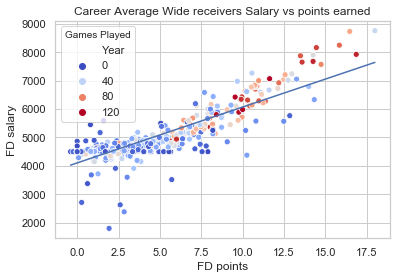

In [1257]:
g = sns.scatterplot(WR.groupby(['Name'])['FD points'].mean(), WR.groupby(['Name'])['FD salary'].mean(), hue=WR.groupby(['Name'])['Year'].count(),
               palette="coolwarm", )
plt.legend(title='Games Played', loc='upper left')
plt.plot(np.unique(WR.groupby(['Name'])['FD points'].mean()), np.poly1d(np.polyfit(WR.groupby(['Name'])['FD points'].mean()
                                                                                   , WR.groupby(['Name'])['FD salary'].mean(), 1))(np.unique(WR.groupby(['Name'])['FD points'].mean())))
plt.title('Career Average Wide receivers Salary vs points earned')
plt.show()

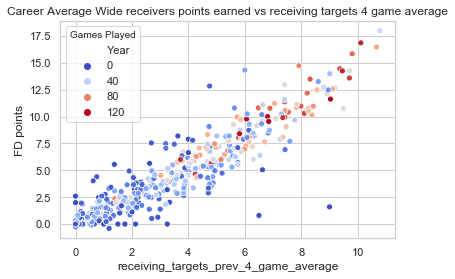

In [1256]:
g = sns.scatterplot(WR.groupby(['Name'])['receiving_targets_prev_4_game_average'].mean(), WR.groupby(['Name'])['FD points'].mean(), hue=WR.groupby(['Name'])['Year'].count(),
               palette="coolwarm", )
plt.legend(title='Games Played', loc='upper left')
plt.title('Career Average Wide receivers points earned vs receiving targets 4 game average')
plt.show()

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(WRXTRAIN_2017, WRYTRAIN_2017)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print('p-value:', p_value)
print('Standard error:', std_err)

In [1200]:
#function to save a model in for each unique position dataframe
def model(DF):    
    #One hot encoding for categorical variables
    #creating function for one-hot encoding of relevant categorical variables
    #encoding list and prefix_list for One_hot_encoder
    to_encode=['Oppt_prev_week', 'Oppt_prev_2_week', 'h/a_prev_week', 'h/a_prev_2_week', 'Oppt', 'Team', 'h/a']
    prefix_list=['Oppt_prev_week', 'Oppt_prev_2_week', 'h/a_prev_week', 'h/a_prev_2_week', 'Oppt', 'Team', 'h/a']
    
    def One_hot_encoder(DF, feature_list, prefix_list):
        for x, i in zip(feature_list, prefix_list):
            a=pd.get_dummies(DF[x], prefix=i)
            DF=pd.concat([DF, a], axis=1)
        return DF
    DF = One_hot_encoder(DF, to_encode, prefix_list)
    
    from sklearn.preprocessing import normalize
    #prepping Training and Test dataset
    TRAIN_SAMPLE = DF[DF.Year != 2017].drop(columns=(to_delete))
    TRAIN_X = TRAIN_SAMPLE.drop(columns=(['FD points']))
    TRAIN_Y = TRAIN_SAMPLE['FD points']
    TRAIN_X = TRAIN_X.drop(columns=(to_encode))  
    TRAIN_X_norm = normalize(TRAIN_X)
    TRAIN_Y_log = np.log(TRAIN_Y+3)

    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestRegressor
    rfr=RandomForestRegressor(n_estimators=100, criterion='mae', n_jobs=-1)
    gbr = GradientBoostingRegressor(n_estimators=300, loss='lad')
    gbr.fit(TRAIN_X, TRAIN_Y)
    print('model score:', gbr.score(TRAIN_X, TRAIN_Y))
    return gbr.fit(TRAIN_X, TRAIN_Y)


#points predictor function to plug the saved model into, with week, year, and uniqe position dataframe parameters
def points_predictor(DF, year, week, model):
    to_encode=['Oppt_prev_week', 'Oppt_prev_2_week', 'h/a_prev_week', 'h/a_prev_2_week', 'Oppt', 'Team', 'h/a']
    prefix_list=['Oppt_prev_week', 'Oppt_prev_2_week', 'h/a_prev_week', 'h/a_prev_2_week', 'Oppt', 'Team', 'h/a']
    def One_hot_encoder(DF, feature_list, prefix_list):
        for x, i in zip(feature_list, prefix_list):
            a=pd.get_dummies(DF[x], prefix=i)
            DF=pd.concat([DF, a], axis=1)
        return DF
    DF = One_hot_encoder(DF, to_encode, prefix_list)
    
    #Test samples (all of 2017)
    TEST_SAMPLE = DF[(DF.Year == year) & (DF.Week == week)].drop(columns=(to_delete))
    TEST_X = TEST_SAMPLE.drop(columns=('FD points'))
    TEST_Y = TEST_SAMPLE['FD points']
    TEST_X = TEST_X.drop(columns=(to_encode))
    TEST_X_norm = normalize(TEST_X)
    TEST_Y_log = np.log(TEST_Y+3)

    Y_PREDICT = model.predict(TEST_X)
    predictions = pd.DataFrame(Y_PREDICT)
    predictions['Y_ACTUAL'] = [x for x in TEST_Y]
    predictions = predictions.rename(columns={0: 'Y_PREDICT'})
    predictions['Name'] = [x for x in DF.Name[(DF.Year == year)&(DF.Week == week)]]
    predictions['salary'] = [x for x in DF['FD salary'][(DF.Year == year)&(DF.Week == week)]]
    predictions['FD points'] = [x for x in DF['FD points'][(DF.Year == year)&(DF.Week == week)]]
    predictions['positions'] = [x for x in DF['Pos'][(DF.Year == year)&(DF.Week == week)]]
    predictions['team'] = [x for x in DF['Team'][(DF.Year == year)&(DF.Week == week)]]
    return predictions


In [1201]:
#Defense had signicantly less attributes, so made its own unique function to reduce dataframe cleaning/removing times
def points_predictor_Def (DF, year, week):
    DF=DF.reset_index()
    to_delete=['GID', 'Name', 'Pos', 'FD salary', 'player_id']
    #One hot encoding for categorical variables
    #creating function for one-hot encoding of relevant categorical variables
    to_encode=['Oppt', 'Team', 'h/a']
    prefix_list=['Oppt', 'Team', 'h/a']
    
    def One_hot_encoder(DF, feature_list, prefix_list):
        for x, i in zip(feature_list, prefix_list):
            a=pd.get_dummies(DF[x], prefix=i)
            DF=pd.concat([DF, a], axis=1)
        return DF
    #encoding list and prefix_list for One_hot_encoder
    DF = One_hot_encoder(DF, to_encode, prefix_list)
    
    from sklearn.preprocessing import normalize
    #prepping Training and Test dataset
    TRAIN_SAMPLE = DF[DF.Year != 2017].drop(columns=(to_delete))
    TRAIN_X = TRAIN_SAMPLE.drop(columns=(['FD points']))
    TRAIN_Y = TRAIN_SAMPLE['FD points']
    TRAIN_X = TRAIN_X.drop(columns=(to_encode))  
    TRAIN_X_norm = normalize(TRAIN_X)
    TRAIN_Y_log = np.log(TRAIN_Y+4.5)

    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_val_score
    gbr = GradientBoostingRegressor(n_estimators=300, loss='lad')
    rfr = RandomForestRegressor(n_estimators=100)
    gbr.fit(TRAIN_X, TRAIN_Y)
    print('model score:', gbr.score(TRAIN_X, TRAIN_Y))

    #Test samples (all of 2017)
    TEST_SAMPLE = DF[(DF.Year == year) & (DF.Week == week)].drop(columns=(to_delete))
    TEST_X = TEST_SAMPLE.drop(columns=('FD points'))
    TEST_Y = TEST_SAMPLE['FD points']
    TEST_X = TEST_X.drop(columns=(to_encode))
    TEST_X_norm = normalize(TEST_X)
    TEST_Y_log = np.log(TEST_Y+4.5)

    Y_PREDICT = gbr.predict(TEST_X)
    predictions = pd.DataFrame(Y_PREDICT)
    predictions['Y_ACTUAL'] = [x for x in TEST_Y_log]
    predictions = predictions.rename(columns={0: 'Y_PREDICT'})
    predictions['Name'] = [x for x in DF.Name[(DF.Year == year)&(DF.Week == week)]]
    predictions['salary'] = [x for x in DF['FD salary'][(DF.Year == year)&(DF.Week == week)]]
    predictions['FD points'] = [x for x in DF['FD points'][(DF.Year == year)&(DF.Week == week)]]
    predictions['positions'] = [x for x in DF['Pos'][(DF.Year == year)&(DF.Week == week)]]
    predictions['team'] = [x for x in DF['Team'][(DF.Year == year)&(DF.Week == week)]]
    return predictions


### Based on injuries or personal bias use player_drop to have model not consider particular players 

In [856]:
# Function for, when in production, we can drop injured players or players we don't want in our final lineups
def player_drop(DF, name):
    DF=pd.concat([DF,DF[DF['Player Name'] == name]]).drop_duplicates(keep=False)
    return DF

#assign new dataframe without injured player
new = player_drop(Week_10_2017, 'tyrod taylor')

In [1203]:
# Instantiating and saving our models
gbrQB = model(QB)
gbrWR = model(WR)
gbrRB = model(RB)
gbrTE = model(TE)

model score: 0.44596846017089586
model score: 0.37533455892168033
model score: 0.45596752064735957
model score: 0.33230773417860116


    QB gbr_notnormed model score: 0.44180979689681166;	cross_va: [0.30290717 0.34153898 0.36028433 0.3270746  0.27615882]
    WR gbr_notnormed model score: 0.36882813756756294;	cross_va: [0.35429268 0.32374888 0.24439428 0.26094488 0.25239612]
    RB gbr_notnormed model score: 0.45472016635642803;	cross_va: [0.36429197 0.37318375 0.38810594 0.324294   0.35539198]
    TE gbr_notnormed model score: 0.36775689639496945;	cross_va: [0.23473447 0.27355978 0.30319358 0.33419174 0.28093789]

    QB gbr_normed model score: 0.5456926409775867; cross_va: [0.45579218 0.33637519 0.40838689 0.2686443  0.43621913]
    WR gbr_normed model score: 0.41756530558623317; cross_va: [0.35989153 0.40459748 0.37957465 0.35256781 0.39613063]
    RB gbr_normed model score: 0.5151024985146688; cross_va: [0.46627542 0.50584947 0.55716383 0.51169075 0.29321797]
    TE gbr_normed model score: 0.4273565863310725; cross_va: [0.32027728 0.35157672 0.40021794 0.40108763 0.42450412]

The models are not describing a great amount of variance; however, the expectation for R^2 is lower when trying to predict athletic performance.  There is an enormous amount of variance involved with sports.  As long as the predictions can help us win Fan Duel competitions, they are valuable.  Explaining ~40% of variance with human athletic performance is not bad. Context matters.

Here our normalized data is easier to predict - our metrics our better.  However, later when we plug this into our optimizer, we can see that the non-normalized predictions are actually better at maximizing Fan Duel points.  The reason is because normalized values bring better players closer to the population average.  The optimizer than undervalues better players.  We in fact want more variance, and the chance of picking a player who may have a big performance one week.

In [1181]:
# Instantiating and saving our models
rfrQB = model(QB)
rfrWR = model(WR)
rfrRB = model(RB)
rfrTE = model(TE)

model score: 0.9050999607416997
model score: 0.9058628836358896
model score: 0.9192337289346422
model score: 0.9026997760601294


    QB rfr_notnormed model score: 0.906890535794649;	cross_va: [0.32335351 0.36853598 0.35911184 0.30732574 0.32393582]
    WR rfr_notnormed model score: 0.9018739005687333;	cross_va: [0.28926124 0.25385466 0.27688006 0.33224823 0.30440299]
    RB rfr_notnormed model score: 0.9174203198879174;	cross_va: [0.35630565 0.45931457 0.41424991 0.37787445 0.41222407]
    T Erfr_notnormed model score: 0.9038090592070069;	cross_va: [0.28042494 0.31919582 0.33017283 0.23624975 0.38732065]

In [1208]:
# Setting up test dataframes to run through Genetic algorithm test script
# We get player predictions for weeks 6-11 in 2017 from our models we saved earlier
# Using these prediction we plug these into our genetic optimizer algorithm to get
# a series of optimized lineups

DF_list=[] #The list of predicted points for each week(which is a DF). We run this through our model tester.

QB_prediction = points_predictor(QB, 2017, 5, rfrQB)
WR_prediction = points_predictor(WR, 2017, 5, rfrWR)
RB_prediction = points_predictor(RB, 2017, 5, rfrRB)
TE_prediction = points_predictor(TE, 2017, 5, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 5)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_5_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_5_2017.reset_index(inplace=True)
Week_5_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_5_2017 = pd.concat([Week_5_2017, Week_5_2017[Week_5_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_5_2017)
print('Week 5 done')

QB_prediction = points_predictor(QB, 2017, 6, rfrQB)
WR_prediction = points_predictor(WR, 2017, 6, rfrWR)
RB_prediction = points_predictor(RB, 2017, 6, rfrRB)
TE_prediction = points_predictor(TE, 2017, 6, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 6)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_6_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_6_2017.reset_index(inplace=True)
Week_6_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_6_2017 = pd.concat([Week_6_2017, Week_6_2017[Week_6_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_6_2017)
print('Week 6 done')

QB_prediction = points_predictor(QB, 2017, 7, rfrQB)
WR_prediction = points_predictor(WR, 2017, 7, rfrWR)
RB_prediction = points_predictor(RB, 2017, 7, rfrRB)
TE_prediction = points_predictor(TE, 2017, 7, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 7)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_7_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_7_2017.reset_index(inplace=True)
Week_7_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_7_2017 = pd.concat([Week_7_2017, Week_7_2017[Week_7_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_7_2017)
print('Week 7 done')

QB_prediction = points_predictor(QB, 2017, 8, rfrQB)
WR_prediction = points_predictor(WR, 2017, 8, rfrWR)
RB_prediction = points_predictor(RB, 2017, 8, rfrRB)
TE_prediction = points_predictor(TE, 2017, 8, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 8)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_8_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_8_2017.reset_index(inplace=True)
Week_8_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_8_2017 = pd.concat([Week_8_2017, Week_8_2017[Week_8_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_8_2017)
print('Week 8 done')

QB_prediction = points_predictor(QB, 2017, 9, rfrQB)
WR_prediction = points_predictor(WR, 2017, 9, rfrWR)
RB_prediction = points_predictor(RB, 2017, 9, rfrRB)
TE_prediction = points_predictor(TE, 2017, 9, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 9)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_9_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_9_2017.reset_index(inplace=True)
Week_9_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_9_2017 = pd.concat([Week_9_2017, Week_9_2017[Week_9_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_9_2017)
print('Week 9 done')

QB_prediction = points_predictor(QB, 2017, 10, rfrQB)
WR_prediction = points_predictor(WR, 2017, 10, rfrWR)
RB_prediction = points_predictor(RB, 2017, 10, rfrRB)
TE_prediction = points_predictor(TE, 2017, 10, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 10)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_10_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_10_2017.reset_index(inplace=True)
Week_10_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_10_2017 = pd.concat([Week_10_2017, Week_10_2017[Week_10_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_10_2017)
print('Week 10 done')

QB_prediction = points_predictor(QB, 2017, 11, rfrQB)
WR_prediction = points_predictor(WR, 2017, 11, rfrWR)
RB_prediction = points_predictor(RB, 2017, 11, rfrRB)
TE_prediction = points_predictor(TE, 2017, 11, rfrTE)
Def_prediction = points_predictor_Def(Def, 2017, 11)
#concatenating into final prediction dataframe
#renaming columns to match columns in Genetic Algorithm
Week_11_2017 = pd.concat([QB_prediction, WR_prediction, RB_prediction, TE_prediction, Def_prediction], axis=0)
Week_11_2017.reset_index(inplace=True)
Week_11_2017.rename(columns={'Name':'Player Name', 'Y_PREDICT':'Proj FP', 'salary':'Salary', 'positions':'Pos'}, inplace=True)
# Dropping players with 0 salary, not in the competition
Week_11_2017 = pd.concat([Week_11_2017, Week_11_2017[Week_11_2017['Salary'] == 0]]).drop_duplicates(keep=False)
DF_list.append(Week_11_2017)
print('Week 11 done')

model score: 0.5090138837522284
Week 5 done
model score: 0.48574684310816907
Week 6 done
model score: 0.5273777588172921
Week 7 done
model score: 0.5020583699039134
Week 8 done
model score: 0.5193039901989867
Week 9 done
model score: 0.48400073766908797
Week 10 done
model score: 0.4734198581754663
Week 11 done


In [1218]:
from sklearn.metrics import mean_squared_error

print('Week 5 RMSE:', np.sqrt(mean_squared_error(Week_5_2017['Proj FP'], Week_5_2017['FD points'])))
print('Week 6 RMSE:', np.sqrt(mean_squared_error(Week_6_2017['Proj FP'], Week_6_2017['FD points'])))
print('Week 7 RMSE:', np.sqrt(mean_squared_error(Week_7_2017['Proj FP'], Week_7_2017['FD points'])))
print('Week 8 RMSE:', np.sqrt(mean_squared_error(Week_8_2017['Proj FP'], Week_8_2017['FD points'])))
print('Week 9 RMSE:', np.sqrt(mean_squared_error(Week_9_2017['Proj FP'], Week_9_2017['FD points'])))
print('Week 10 RMSE:', np.sqrt(mean_squared_error(Week_10_2017['Proj FP'], Week_10_2017['FD points'])))
print('Week 11 RMSE:', np.sqrt(mean_squared_error(Week_11_2017['Proj FP'], Week_11_2017['FD points'])))


Week 5 RMSE: 6.093415030394758
Week 6 RMSE: 6.6831266864110725
Week 7 RMSE: 6.368027609468873
Week 8 RMSE: 5.73895730514759
Week 9 RMSE: 5.756752057441479
Week 10 RMSE: 5.866258112374222
Week 11 RMSE: 6.113969344556105


Our RMSE values show a standard error of about 6 points of off how the player actually performs.  

Text(0.5, 1.0, 'Week 8')

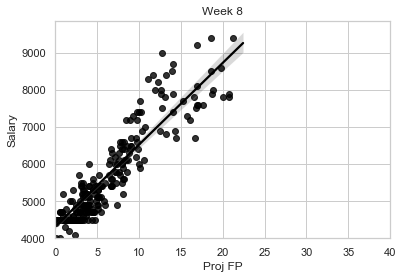

In [1249]:
sns.regplot(Week_8_2017['Proj FP'], Week_8_2017['Salary'], color='black')
plt.ylim(bottom=4000)
plt.xlim(right=40, left=0)
plt.title('Week 8')

Text(0.5, 1.0, 'Week 8')

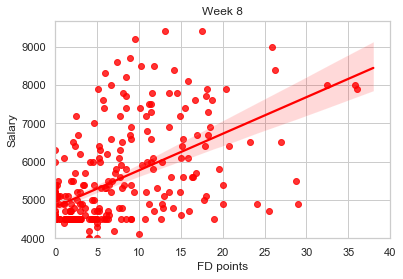

In [1250]:
sns.regplot(Week_8_2017['FD points'], Week_8_2017['Salary'], color='red')
plt.ylim(bottom=4000)
plt.xlim(right=40, left=0)
plt.title('Week 8')

Text(0.5, 1.0, 'Week 8 Residuals plot')

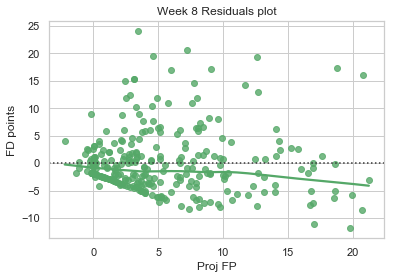

In [1251]:
sns.residplot(Week_8_2017['Proj FP'], Week_8_2017['FD points'], lowess=True, color="g")
plt.title('Week 8 Residuals plot')

The residuals plot of actual points versus the the predicted points show the differences follow a uniform distribution , but one which slightly leans toward the predicted values - meaning the predicted values are underpredicting slightly.

Next we will be plugging the weekly player predictions into a genetic algorithm which is an optimizer.  Our two constraints are positions and the salary cap while trying to maximize points scored.  Below we ran the genetic algorithm 30 times for each week.  Each run of the genetic algorithm produces 250 optimized lineups, all slightly different form the last as it iterates. The algorithm will also return a best individual lineup it thinks will be the best - this is the lineup we will consider for each run.

Next we plot the actual points scored for each 'best lineup' from the optimizer.  Our target is 120 points, which is generally around where one needs to score to win Fan Duel competitions.  For arguments sake let's count entries over 120 as wins and under 120 as losses

### Genetic Algorithm from 
https://github.com/jm-chase/evolve-dfs/blob/master/genalg.py

In [ ]:
# %load genalg
"""
    pyeasyga module

"""
import random
import numpy as np
import pandas as pd
import copy
from operator import attrgetter

from six.moves import range


class GeneticAlgorithm(object):
    """Genetic Algorithm class.

    This is the main class that controls the functionality of the Genetic
    Algorithm.

    """

    def __init__(self,
                 seed_data,
                 population_size=50,
                 generations=100,
                 crossover_probability=0.8,
                 mutation_probability=0.2,
                 elitism=True,
                 maximise_fitness=True,
                 oneToZeroRatio=None,
                 categories='Baseball'):
        """Instantiate the Genetic Algorithm.

        :param seed_data: input data to the Genetic Algorithm 
        :type seed_data: pandas dataframe
        :param int population_size: size of population
        :param int generations: number of generations to evolve
        :param float crossover_probability: probability of crossover operation
        :param float mutation_probability: probability of mutation operation
        :param list categories: 'Baseball' or 'Football'. Tells us what our genes (positions)
        are composed of. 
        """

        self.seed_data = seed_data
        self.population_size = population_size
        self.generations = generations
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
        self.elitism = elitism
        self.maximise_fitness = maximise_fitness
        self.oneToZeroRatio = oneToZeroRatio
        if categories == 'Baseball': 
            self.categories = ['OF1', 'OF2', 'OF3','SP1', 'SP2', '1B','2B','3B','SS','C']
        elif categories == 'Football':
            self.categories = ['WR1', 'WR2', 'WR3', 'QB','RB1','RB2','TE','FLEX','D']

        else: 
            self.categories = None
        self.current_generation = []

        def create_individual(seed_data):
            """Create a candidate solution representation.

            :param seed_data: input data to the Genetic Algorithm
            :type seed_data: pandas dataframe
            :returns: candidate solution representation as a dictionary mapping
                position to player. Genes are the players, lineups are the individuals.

            """

            previously_chosen = []
            individuals = {gene: randomlySelect(gene,seed_data,previously_chosen) for gene in self.categories}
            return individuals

        def randomlySelect(key,seed_data,previously_chosen):
            """ This function randomly selects players from each
            category to construct an initial linup and does a check to make sure
            that we aren't picking the same player twice in the case where a player
            can play more than one position """

            # Remove the index of categories that have multiple slots
            already_chosen = True
            while already_chosen:   
                key = ''.join([i for i in key if not i.isdigit()])
                if key == 'FLEX':
                    seed_data = seed_data[(seed_data['Pos'] == 'WR') | (seed_data['Pos'] == 'RB') | (seed_data['Pos'] == 'TE')].reset_index(drop=True)
                else:
                    seed_data = seed_data[seed_data['Pos'].str.contains(key)].reset_index(drop=True)
                index = random.randrange(len(seed_data))
                value = (seed_data.get_value(index,'Player Name'),seed_data.get_value(index,'Proj FP'),seed_data.get_value(index,'Salary'))
                if value[0] not in previously_chosen:
                    already_chosen = False 
                    previously_chosen.append(value[0])
            # print(previously_chosen)
            return value

        def crossover(parent_1, parent_2):
            """Crossover (mate) two parents to produce two children.

            :param parent_1: candidate solution representation (list)
            :param parent_2: candidate solution representation (list)
            :returns: tuple containing two children

            """
            def exist_duplicates_values(values):
                return len(set(values)) != len(values)

            exist_duplicates = True
            while exist_duplicates:
                index = random.randrange(1, len(parent_1))
                keys = list(parent_1.keys())
                random.shuffle(keys)
                child_1 = { key:(parent_1[key] if i <= index else parent_2[key]) for key,i in zip(keys,range(len(self.categories))) }
                exist_duplicates = exist_duplicates_values(child_1.values())

            exist_duplicates = True
            while exist_duplicates:
                index = random.randrange(1, len(parent_2))
                keys = list(parent_2.keys())
                random.shuffle(keys)
                child_2 = {key:(parent_2[key] if i <= index else parent_1[key]) for key,i in zip(keys,range(len(self.categories)))}
                exist_duplicates = exist_duplicates_values(child_2.values())
    
            return child_1, child_2

        def mutate(individual,seed_data):
            """Reverse the bit of a random index in an individual."""
            mutate_index = random.randrange(len(individual))
            keys = list(individual.keys())
            k = keys[mutate_index]
            previously_chosen = [individual[key][0] for key in keys if key != k]
            individual[k] = randomlySelect(k,seed_data,previously_chosen)
            # print([individual[key][0] for key in individual])
            # individual[mutate_index] = (0, 1)[individual[mutate_index] == 0]

        def random_selection(population):
            """Select and return a random member of the population."""
            return random.choice(population)

        def tournament_selection(population):
            """Select a random number of individuals from the population and
            return the fittest member of them all.
            """
            if self.tournament_size == 0:
                self.tournament_size = 2
            members = random.sample(population, self.tournament_size)
            members.sort(
                key=attrgetter('fitness'), reverse=self.maximise_fitness)
            return members[0]

        self.fitness_function = None
        self.tournament_selection = tournament_selection
        self.tournament_size = self.population_size // 10
        self.random_selection = random_selection
        self.create_individual = create_individual
        self.crossover_function = crossover
        self.mutate_function = mutate
        self.selection_function = self.tournament_selection

    def create_initial_population(self):
        """Create members of the first population randomly.
        """
        initial_population = []
        for _ in range(self.population_size):
            genes = self.create_individual(self.seed_data)
            individual = Chromosome(genes)
            initial_population.append(individual)
        self.current_generation = initial_population

    def calculate_population_fitness(self):
        """Calculate the fitness of every member of the given population using
        the supplied fitness_function.
        """
        for individual in self.current_generation:
            individual.fitness = self.fitness_function(
                individual.genes, self.seed_data)
        # print(individual.fitness)
    def rank_population(self):
        """Sort the population by fitness according to the order defined by
        maximise_fitness.
        """
        self.current_generation.sort(
            key=attrgetter('fitness'), reverse=self.maximise_fitness)

    def create_new_population(self):
        """Create a new population using the genetic operators (selection,
        crossover, and mutation) supplied.
        """
        new_population = []
        elite = copy.deepcopy(self.current_generation[0])
        selection = self.selection_function

        while len(new_population) < self.population_size:
            parent_1 = copy.deepcopy(selection(self.current_generation))
            parent_2 = copy.deepcopy(selection(self.current_generation))

            child_1, child_2 = parent_1, parent_2
            child_1.fitness, child_2.fitness = 0, 0

            can_crossover = random.random() < self.crossover_probability
            can_mutate = random.random() < self.mutation_probability

            if can_crossover:
                child_1.genes, child_2.genes = self.crossover_function(
                    parent_1.genes, parent_2.genes)

            if can_mutate:
                self.mutate_function(child_1.genes,self.seed_data)
                self.mutate_function(child_2.genes,self.seed_data)

            new_population.append(child_1)
            if len(new_population) < self.population_size:
                new_population.append(child_2)

        if self.elitism:
            new_population[0] = elite

        self.current_generation = new_population

    def create_first_generation(self):
        """Create the first population, calculate the population's fitness and
        rank the population by fitness according to the order specified.
        """
        self.create_initial_population()
        self.calculate_population_fitness()
        self.rank_population()
    
    

    def create_next_generation(self):
        """Create subsequent populations, calculate the population fitness and
        rank the population by fitness in the order specified.
        """
        self.create_new_population()
        self.calculate_population_fitness()
        self.rank_population()

    def run(self):
        """Run (solve) the Genetic Algorithm."""
        self.create_first_generation()

        for _ in range(1, self.generations):
            self.create_next_generation()

    def best_individual(self):
        """Return the individual with the best fitness in the current
        generation.
        """
        best = self.current_generation[0]
        return (best.fitness, best.genes)

    def last_generation(self):
        """Return members of the last generation as a generator function."""
        return ((member.fitness, member.genes) for member
                in self.current_generation)


class Chromosome(object):
    """ Chromosome class that encapsulates an individual's fitness and solution
    representation.
    """
    def __init__(self, genes):
        """Initialise the Chromosome."""
        self.genes = genes
        self.fitness = 0

    def __repr__(self):
        """Return initialised Chromosome representation in human readable form.
        """
        return repr((self.fitness, self.genes))


In [ ]:
# %load generate_lineups
import genalg
import pandas as pd
import numpy as np 

# Draft Kings Salary Cap
salarycap = 50000

# Define a fitness function
def fitness(individual, data):
 
    currentSolutionCost = 0
    currentSolutionPoints = 0
    possibleTeam = False
    for value in individual.values():
        currentSolutionCost += value[2]
        currentSolutionPoints += value[1]
    if (currentSolutionCost <= salarycap):
        return currentSolutionPoints
    return 0

def getUniqueLineups(lineups,predicted_points):
    unique_lists = []
    unique_points = []
    for l,points in zip(lineups,predicted_points): 
        l_unique = True
        for u in unique_lists:
            if set(l) == set(u):
                l_unique = False

        if (l_unique):
            unique_lists.append(np.array(l))
            unique_points.append(points)
    return unique_lists, unique_points

""" FOR FOOTBALL COMMENT TO HIDE """

# Load Data
offense = pd.read_csv('./NFL/OffenseWeek1.csv')
defense = pd.read_csv('./NFL/DefenseWeek1.csv')
df = pd.concat([offense,defense])

# Run the genetic algorithm
ga = genalg.GeneticAlgorithm(df,population_size=500,generations=100,mutation_probability=0.2,categories='Football') 
ga.fitness_function = fitness              
ga.run()                                 

# Get List of lineups from last generation
chosen_lineups = [[g[1][key][0] for key in g[1]] for g in ga.last_generation() if g[0] > 0 ]
predicted_points = [g[0] for g in ga.last_generation() if g[0] > 0]

# Filter For Unique Lineups
unique_lineups, unique_points = getUniqueLineups(chosen_lineups,predicted_points)
unique_lineups =  pd.DataFrame(unique_lineups).transpose()

# Print best lineup and  save last generation to CSV
print(ga.best_individual())
unique_lineups.to_csv('./lineupsNFL.csv',index=False)

""" FOR BASEBALL UNCOMMENT TO USE """ 

# # Load Data
# df = pd.read_csv('./MLB/9-11-2017proj.csv')

# # Run the genetic algorithm
# ga = genalg.GeneticAlgorithm(df,population_size=500,generations=100,mutation_probability=0.2,categories='Baseball') 
# ga.fitness_function = fitness              
# ga.run()   

# # Get List of lineups from last generation
# chosen_lineups = [[g[1][key][0] for key in g[1]] for g in ga.last_generation() if g[0] > 0 ]
# predicted_points = [g[0] for g in ga.last_generation() if g[0] > 0]

# # Filter For Unique Lineups
# unique_lineups, unique_points = getUniqueLineups(chosen_lineups,predicted_points)
# unique_lineups =  pd.DataFrame(unique_lineups).transpose()

# # Print best lineup and  save last generation to CSV
# print(ga.best_individual())
# unique_lineups.to_csv('./lineupsMLB.csv',index=False)





C:\Users\chase\Final_Capstone\Fantasy-FF\genalg.py:91: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  value = (seed_data.get_value(index,'Player Name'),seed_data.get_value(index,'Proj FP'),seed_data.get_value(index,'Salary'))


(111.8053356351528, {'FLEX': ('sterling shepard', 9.826198628624294, 6000.0), 'RB1': ('jonathan stewart', 10.270923493610484, 5700.0), 'WR1': ('adam humphries', 7.597323722488147, 4700.0), 'WR2': ('brandin cooks', 14.825923710504403, 7500.0), 'D': ('Arizona', 1.7574875152760083, 4300.0), 'RB2': ('kareem hunt', 17.040741266013196, 9000.0), 'QB': ('alex smith', 18.37703116348005, 7400.0), 'WR3': ('antonio brown', 22.35422461904439, 8800.0), 'TE': ('zach ertz', 9.755481516111809, 6600.0)})
(110.13509327125674, {'WR3': ('brandin cooks', 14.825923710504403, 7500.0), 'RB2': ('jonathan stewart', 10.270923493610484, 5700.0), 'WR1': ('antonio brown', 22.35422461904439, 8800.0), 'QB': ('alex smith', 18.37703116348005, 7400.0), 'TE': ('martellus bennett', 7.291323646460775, 5300.0), 'D': ('Arizona', 1.7574875152760083, 4300.0), 'FLEX': ('sterling shepard', 9.826198628624294, 6000.0), 'WR2': ('tyreek hill', 13.847710893417279, 7400.0), 'RB1': ('leonard fournette', 11.584269600839018, 7600.0)})
(11

(111.63329949596478, {'FLEX': ('chris hogan', 12.118320359087294, 7000.0), 'WR3': ('brandin cooks', 14.825923710504403, 7500.0), 'WR2': ('antonio brown', 22.35422461904439, 8800.0), 'D': ('Arizona', 1.7574875152760083, 4300.0), 'WR1': ('adam humphries', 7.597323722488147, 4700.0), 'RB1': ('jonathan stewart', 10.270923493610484, 5700.0), 'RB2': ('kareem hunt', 17.040741266013196, 9000.0), 'TE': ('martellus bennett', 7.291323646460775, 5300.0), 'QB': ('alex smith', 18.37703116348005, 7400.0)})
(110.81021849639009, {'RB1': ('jonathan stewart', 10.270923493610484, 5700.0), 'WR1': ('antonio brown', 22.35422461904439, 8800.0), 'D': ('Arizona', 1.7574875152760083, 4300.0), 'WR2': ('brandin cooks', 14.825923710504403, 7500.0), 'WR3': ('sterling shepard', 9.826198628624294, 6000.0), 'RB2': ('kareem hunt', 17.040741266013196, 9000.0), 'FLEX': ('ameer abdullah', 9.066364453376458, 6000.0), 'QB': ('alex smith', 18.37703116348005, 7400.0), 'TE': ('martellus bennett', 7.291323646460775, 5300.0)})
(1

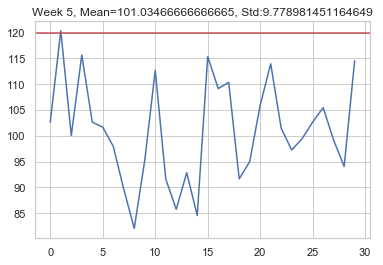

(104.61146744262682, {'WR2': ('larry fitzgerald', 15.058652811378225, 6600.0), 'WR1': ('robby anderson', 9.700692078185224, 5600.0), 'FLEX': ('lamar miller', 14.730798278918249, 6800.0), 'TE': ('cameron brate', 8.15548950829025, 5900.0), 'D': ('Carolina', -1.5789291147612876, 4500.0), 'QB': ('carson wentz', 18.38074668770335, 7600.0), 'RB2': ("le'veon bell", 17.164235732114552, 9000.0), 'WR3': ('julio jones', 14.38665872165651, 8400.0), 'RB1': ('legarrette blount', 8.613122739141726, 5600.0)})
(103.47325831463402, {'RB1': ("le'veon bell", 17.164235732114552, 9000.0), 'WR3': ('larry fitzgerald', 15.058652811378225, 6600.0), 'D': ('Carolina', -1.5789291147612876, 4500.0), 'TE': ('jared cook', 6.905768443491217, 5400.0), 'WR2': ('chris hogan', 10.758739818122818, 7500.0), 'QB': ('tom brady', 24.34081057868251, 9500.0), 'FLEX': ('lamar miller', 14.730798278918249, 6800.0), 'RB2': ('legarrette blount', 8.613122739141726, 5600.0), 'WR1': ('ted ginn', 7.480059027546008, 5100.0)})
(106.7015802

(105.5403088289527, {'RB1': ("le'veon bell", 17.164235732114552, 9000.0), 'D': ('Arizona', -1.7305549270498362, 4200.0), 'RB2': ('lamar miller', 14.730798278918249, 6800.0), 'WR3': ('larry fitzgerald', 15.058652811378225, 6600.0), 'WR1': ('adam thielen', 9.609499483884779, 6500.0), 'WR2': ('robby anderson', 9.700692078185224, 5600.0), 'TE': ('martellus bennett', 7.701469838898911, 5500.0), 'QB': ('philip rivers', 16.55669794035607, 7200.0), 'FLEX': ('leonard fournette', 16.748817592266512, 8600.0)})
(107.81519909746449, {'WR2': ('larry fitzgerald', 15.058652811378225, 6600.0), 'WR3': ('rishard matthews', 8.853721573322492, 5400.0), 'D': ('Jacksonville', -0.5239354953230457, 4900.0), 'FLEX': ('lamar miller', 14.730798278918249, 6800.0), 'RB2': ("le'veon bell", 17.164235732114552, 9000.0), 'QB': ('carson wentz', 18.38074668770335, 7600.0), 'RB1': ('leonard fournette', 16.748817592266512, 8600.0), 'WR1': ('robby anderson', 9.700692078185224, 5600.0), 'TE': ('martellus bennett', 7.70146983

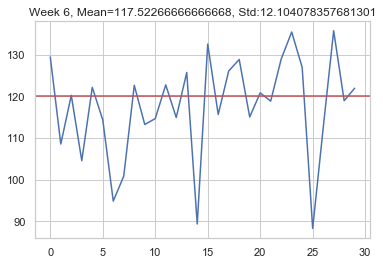

(108.34657416483962, {'FLEX': ('ezekiel elliott', 17.8367370673857, 8700.0), 'RB1': ('melvin gordon', 17.7814713729836, 7700.0), 'RB2': ('joe mixon', 8.39947568056427, 5600.0), 'WR2': ('antonio brown', 17.955991323959, 9300.0), 'WR1': ('adam thielen', 11.802229707075512, 6900.0), 'TE': ('marcedes lewis', 8.045745684919659, 4500.0), 'D': ('Chicago', -1.4786726445491076, 4300.0), 'QB': ('alex smith', 18.76122943322718, 7600.0), 'WR3': ('tyler lockett', 9.242366539273783, 5300.0)})
(105.54240213553894, {'WR1': ('tyler lockett', 9.242366539273783, 5300.0), 'WR2': ('antonio brown', 17.955991323959, 9300.0), 'WR3': ('robert woods', 10.352641455008373, 5500.0), 'D': ('Jacksonville', -1.344324349114632, 5400.0), 'TE': ('jimmy graham', 8.76071505316983, 5800.0), 'FLEX': ('jordy nelson', 12.938068127351077, 7400.0), 'QB': ('alex smith', 18.76122943322718, 7600.0), 'RB1': ('melvin gordon', 17.7814713729836, 7700.0), 'RB2': ('bilal powell', 11.094243179680696, 6000.0)})
(106.90076933966942, {'D': 

(110.63079927926614, {'WR1': ('jordy nelson', 12.938068127351077, 7400.0), 'WR2': ('julio jones', 15.59522168457261, 8800.0), 'WR3': ('robert woods', 10.352641455008373, 5500.0), 'D': ('Chicago', -1.4786726445491076, 4300.0), 'FLEX': ('melvin gordon', 17.7814713729836, 7700.0), 'QB': ('carson palmer', 18.465343351913514, 7000.0), 'RB2': ('ezekiel elliott', 17.8367370673857, 8700.0), 'RB1': ('bilal powell', 11.094243179680696, 6000.0), 'TE': ('marcedes lewis', 8.045745684919659, 4500.0)})
(108.02154903156172, {'D': ('Chicago', -1.4786726445491076, 4300.0), 'WR1': ('ted ginn', 9.706793507409403, 5500.0), 'RB2': ('ezekiel elliott', 17.8367370673857, 8700.0), 'FLEX': ('mohamed sanu', 8.882617954820649, 5500.0), 'WR2': ('julio jones', 15.59522168457261, 8800.0), 'WR3': ('robert woods', 10.352641455008373, 5500.0), 'QB': ('tom brady', 21.298992949010813, 9200.0), 'TE': ('marcedes lewis', 8.045745684919659, 4500.0), 'RB1': ('melvin gordon', 17.7814713729836, 7700.0)})
(108.28400722659505, {'Q

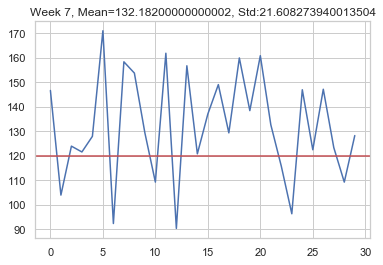

(108.96582002003956, {'WR1': ('antonio brown', 16.916130728713174, 9200.0), 'TE': ('jack doyle', 5.9654868422566665, 4900.0), 'D': ('Seattle', 5.139229356962235, 5100.0), 'WR3': ('tyler lockett', 8.079697993776538, 5200.0), 'RB1': ("le'veon bell", 18.601418323781356, 9400.0), 'WR2': ('marquise goodwin', 7.362085796541726, 4900.0), 'RB2': ('mark ingram', 16.04373266696612, 7200.0), 'QB': ('russell wilson', 20.800958604399042, 7900.0), 'FLEX': ('ted ginn', 10.057079706642682, 5900.0)})
(106.72188006164569, {'D': ('Seattle', 5.139229356962235, 5100.0), 'WR2': ('ted ginn', 10.057079706642682, 5900.0), 'RB1': ('mark ingram', 16.04373266696612, 7200.0), 'FLEX': ('michael thomas', 12.735472090606159, 7500.0), 'RB2': ("le'veon bell", 18.601418323781356, 9400.0), 'QB': ('russell wilson', 20.800958604399042, 7900.0), 'WR1': ('keenan allen', 13.136285524068274, 7800.0), 'WR3': ('ricardo louis', 5.408649221162732, 4700.0), 'TE': ('a.j. derby', 4.799054567057077, 4500.0)})
(108.7331199648957, {'WR2

(108.21310341664578, {'TE': ('cameron brate', 8.61647758317587, 5800.0), 'WR3': ('marquise goodwin', 7.362085796541726, 4900.0), 'WR2': ('antonio brown', 16.916130728713174, 9200.0), 'D': ('Buffalo', 3.262057226910348, 4600.0), 'RB1': ('chris thompson', 10.00772754117895, 6000.0), 'RB2': ('jordan howard', 12.468461178154376, 6900.0), 'FLEX': ('mark ingram', 16.04373266696612, 7200.0), 'WR1': ('michael thomas', 12.735472090606159, 7500.0), 'QB': ('russell wilson', 20.800958604399042, 7900.0)})
(107.4329926274929, {'D': ('Seattle', 5.139229356962235, 5100.0), 'WR1': ('tyrell williams', 9.578914098022695, 6200.0), 'RB2': ('melvin gordon', 14.05258754607701, 7900.0), 'WR2': ('keenan allen', 13.136285524068274, 7800.0), 'TE': ('cameron brate', 8.61647758317587, 5800.0), 'RB1': ('mark ingram', 16.04373266696612, 7200.0), 'QB': ('russell wilson', 20.800958604399042, 7900.0), 'WR3': ('ted ginn', 10.057079706642682, 5900.0), 'FLEX': ('chris thompson', 10.00772754117895, 6000.0)})
(107.885465513

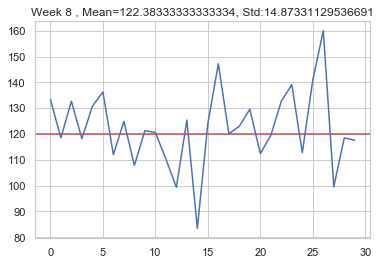

(106.8905504252393, {'RB1': ('ezekiel elliott', 22.22949841719559, 8900.0), 'WR2': ('julio jones', 14.460361660186795, 7900.0), 'TE': ('a.j. derby', 4.936093641067634, 4500.0), 'WR3': ('tyler lockett', 11.153557755002083, 5500.0), 'RB2': ('kareem hunt', 15.878006786209664, 9000.0), 'WR1': ('marvin jones', 9.871106085752498, 6000.0), 'QB': ('alex smith', 19.31320846186392, 7900.0), 'D': ('Seattle', 1.4675446450739655, 5000.0), 'FLEX': ('o.j. howard', 7.581172972887124, 5300.0)})
(107.34415329371043, {'RB1': ('devonta freeman', 11.268717522854036, 7100.0), 'WR1': ('michael thomas', 14.411752255838676, 7600.0), 'RB2': ('ezekiel elliott', 22.22949841719559, 8900.0), 'D': ('Jacksonville', 1.9836738048855005, 5300.0), 'WR3': ('marvin jones', 9.871106085752498, 6000.0), 'TE': ('cameron brate', 8.625852157071646, 6100.0), 'QB': ('alex smith', 19.31320846186392, 7900.0), 'FLEX': ('mike wallace', 8.486786833246477, 5500.0), 'WR2': ('tyler lockett', 11.153557755002083, 5500.0)})
(108.946310835054

(106.46350035115215, {'RB2': ('javorius allen', 8.109177143155353, 5700.0), 'WR1': ('julio jones', 14.460361660186795, 7900.0), 'RB1': ('alvin kamara', 10.717064866038752, 6600.0), 'FLEX': ('ezekiel elliott', 22.22949841719559, 8900.0), 'QB': ('alex smith', 19.31320846186392, 7900.0), 'WR3': ('marvin jones', 9.871106085752498, 6000.0), 'D': ('Jacksonville', 1.9836738048855005, 5300.0), 'WR2': ('tyler lockett', 11.153557755002083, 5500.0), 'TE': ('cameron brate', 8.625852157071646, 6100.0)})
(108.31398884245992, {'FLEX': ('julio jones', 14.460361660186795, 7900.0), 'TE': ('austin hooper', 5.0887308433143374, 4700.0), 'RB1': ('ezekiel elliott', 22.22949841719559, 8900.0), 'WR1': ('michael thomas', 14.411752255838676, 7600.0), 'WR3': ('tyler lockett', 11.153557755002083, 5500.0), 'QB': ('alex smith', 19.31320846186392, 7900.0), 'RB2': ('legarrette blount', 8.47889876556885, 5900.0), 'WR2': ('t.y. hilton', 11.710436038415676, 6600.0), 'D': ('Seattle', 1.4675446450739655, 5000.0)})
(108.207

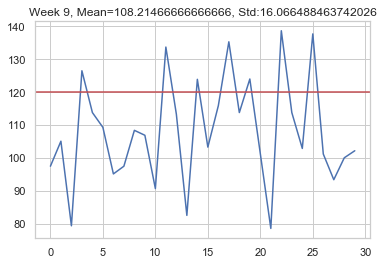

(104.73339566529677, {'QB': ('russell wilson', 19.24853463377541, 8300.0), 'D': ('LA Chargers', 1.1961454878144213, 4200.0), 'WR2': ('tyler lockett', 9.139558160320721, 5600.0), 'WR3': ('deonte thompson', 6.089223518747005, 4800.0), 'WR1': ('a.j. green', 15.378692493346673, 7900.0), 'RB2': ("le'veon bell", 19.321044775781868, 9400.0), 'FLEX': ('jamison crowder', 8.476604393120887, 5500.0), 'RB1': ('leonard fournette', 17.66896598662633, 8700.0), 'TE': ('kyle rudolph', 8.214626215763424, 5400.0)})
(103.75552829609983, {'QB': ('tyrod taylor', 19.085710830063164, 7800.0), 'TE': ('kyle rudolph', 8.214626215763424, 5400.0), 'WR2': ('tyler lockett', 9.139558160320721, 5600.0), 'WR1': ('a.j. green', 15.378692493346673, 7900.0), 'RB1': ("le'veon bell", 19.321044775781868, 9400.0), 'WR3': ('robert woods', 9.265456323021148, 6200.0), 'FLEX': ('julio jones', 14.372593942146516, 8000.0), 'D': ('LA Chargers', 1.1961454878144213, 4200.0), 'RB2': ('isaiah crowell', 7.781700067841871, 5500.0)})
(104.2

(105.55463072071485, {'WR3': ('tyler lockett', 9.139558160320721, 5600.0), 'QB': ('tyrod taylor', 19.085710830063164, 7800.0), 'D': ('LA Chargers', 1.1961454878144213, 4200.0), 'FLEX': ('paul richardson', 9.13934963326367, 5800.0), 'RB1': ("le'veon bell", 19.321044775781868, 9400.0), 'WR2': ('ted ginn', 8.959413058218253, 5900.0), 'TE': ('c.j. fiedorowicz', 5.665750295279732, 4600.0), 'RB2': ('leonard fournette', 17.66896598662633, 8700.0), 'WR1': ('a.j. green', 15.378692493346673, 7900.0)})
(104.71659306396296, {'RB1': ('leonard fournette', 17.66896598662633, 8700.0), 'TE': ('kyle rudolph', 8.214626215763424, 5400.0), 'RB2': ('devonta freeman', 10.270676040592933, 6500.0), 'QB': ('case keenum', 15.422127508415867, 6800.0), 'WR1': ('tyler lockett', 9.139558160320721, 5600.0), 'WR2': ('julio jones', 14.372593942146516, 8000.0), 'WR3': ('deandre hopkins', 13.801723542862598, 7600.0), 'D': ('Cleveland', 0.44762917388787066, 3500.0), 'FLEX': ('a.j. green', 15.378692493346673, 7900.0)})
(10

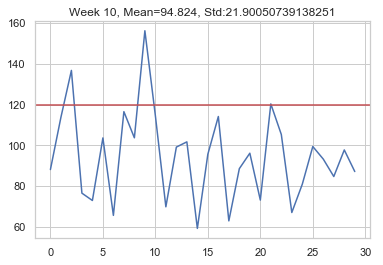

(109.06336649229347, {'RB2': ('alvin kamara', 16.08976160131731, 7500.0), 'RB1': ("le'veon bell", 19.022544621453132, 9500.0), 'WR3': ('jamison crowder', 11.440808155527783, 5400.0), 'WR1': ('ted ginn', 9.005365295772027, 5600.0), 'D': ('Pittsburgh', 0.44486571180437534, 4700.0), 'FLEX': ('adrian peterson', 11.270767771314928, 6600.0), 'WR2': ('amari cooper', 15.385322132225463, 7300.0), 'QB': ('derek carr', 18.188688637772923, 8000.0), 'TE': ('kyle rudolph', 8.215242565105514, 5400.0)})
(106.58945989239928, {'RB1': ('alvin kamara', 16.08976160131731, 7500.0), 'TE': ('kyle rudolph', 8.215242565105514, 5400.0), 'D': ('Seattle', 1.221146493914079, 5000.0), 'QB': ('kirk cousins', 18.225715044604758, 8200.0), 'RB2': ('adrian peterson', 11.270767771314928, 6600.0), 'FLEX': ('ted ginn', 9.005365295772027, 5600.0), 'WR2': ('jamison crowder', 11.440808155527783, 5400.0), 'WR1': ('antonio brown', 15.735330832617386, 9000.0), 'WR3': ('amari cooper', 15.385322132225463, 7300.0)})
(108.80762279344

(108.46909132613249, {'TE': ('kyle rudolph', 8.215242565105514, 5400.0), 'RB1': ('alvin kamara', 16.08976160131731, 7500.0), 'WR1': ('ted ginn', 9.005365295772027, 5600.0), 'RB2': ("le'veon bell", 19.022544621453132, 9500.0), 'QB': ('kirk cousins', 18.225715044604758, 8200.0), 'D': ('Cleveland', 0.4355099838244019, 4000.0), 'WR3': ('robert woods', 10.648821926302073, 6900.0), 'FLEX': ('jamison crowder', 11.440808155527783, 5400.0), 'WR2': ('amari cooper', 15.385322132225463, 7300.0)})
(110.34499378992486, {'D': ('Cleveland', 0.4355099838244019, 4000.0), 'FLEX': ('alvin kamara', 16.08976160131731, 7500.0), 'TE': ('kyle rudolph', 8.215242565105514, 5400.0), 'WR1': ('ted ginn', 9.005365295772027, 5600.0), 'RB1': ("le'veon bell", 19.022544621453132, 9500.0), 'WR2': ('jamison crowder', 11.440808155527783, 5400.0), 'QB': ('dak prescott', 19.47967166338428, 8500.0), 'RB2': ('adrian peterson', 11.270767771314928, 6600.0), 'WR3': ('amari cooper', 15.385322132225463, 7300.0)})
(106.3553889181078

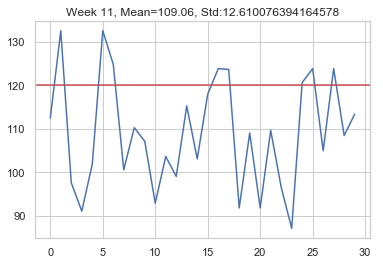

In [1219]:
name_list=['Week 5', 'Week 6', 'Week 7', 'Week 8 ', 'Week 9', 'Week 10', 'Week 11']
for df, name_wk in zip(DF_list, name_list):
    scores_top=[]
    for x in range(1,31): 
        # Run the genetic algorithm
        ga = genalg.GeneticAlgorithm(df,population_size=500,generations=40, crossover_probability=.9, mutation_probability=0.3,
                                     categories='Football') 
        ga.fitness_function = fitness              
        ga.run()                                 

        # Get List of lineups from last generation
        chosen_lineups = [[g[1][key][0] for key in g[1]] for g in ga.last_generation() if g[0] > 0 ]
        predicted_points = [g[0] for g in ga.last_generation() if g[0] > 0]

        # Filter For Unique Lineups
        unique_lineups, unique_points = getUniqueLineups(chosen_lineups,predicted_points)
        unique_lineups =  pd.DataFrame(unique_lineups).transpose()

        # Print best lineup and  save last generation to CSV
        print(ga.best_individual())

        '''Our Genetic algorithm and model validator: This script will save and graph the actual points
        scored by the optimal lineups provided by the Genetic Algorithm.  It takes what the GA thinks is the
        optimal lineup (from 256 lineups) for each run of the algorithm.  We also get the mean, std, and median
        of the top lineups for each week for each run''' 

        combo={}
        for i, j in zip(df['FD points'], df['Player Name']):
            combo[j]=i
        score=[]
        top=[]
        for col in unique_lineups:
            lineup=[]
            for name in unique_lineups[col]:
                if col == 0:
                    if name in combo:
                        top.append(combo[name])
                if name in combo:
                    lineup.append(combo[name])
            score.append(sum(lineup))
        results=sorted(score[:68], reverse=True)
        check = [x for x in results if x > 116.34]
        scores_top.append(np.sum(top))
        
    print(scores_top)
    print('Mean of top 30 predictions for ',x,':', np.mean(scores_top))
    print('Std of top 30 predictions for',x,':', np.std(scores_top))
    print('Median:', np.median(scores_top))
    print('Scores over 126.06 for',x,':',len([x for x in scores_top if x > 126.06]))
    print('unique scores for',x,':',len(np.unique(scores_top)))
    plt.plot(scores_top)
    plt.title(str(name_wk) +', '+'Mean='+str(np.mean(scores_top))+', Std:'+str(np.std(scores_top)))
    plt.axhline(y=120.00, color='r', linestyle='-')
    plt.show()      


In [1258]:
unique_lineups

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,jamison crowder,kyle rudolph,amari cooper,derek carr,Cleveland,kyle rudolph,matt ryan,jamison crowder,le'veon bell,deandre hopkins,deandre hopkins,le'veon bell,jamison crowder,amari cooper,derek carr,vernon davis,derek carr,le'veon bell,Cleveland,alvin kamara,le'veon bell,vernon davis,amari cooper,deandre hopkins,alvin kamara,kyle rudolph,alvin kamara,amari cooper,deandre hopkins,derek carr,alvin kamara,jamison crowder,levine toilolo,latavius murray,deandre hopkins,vernon davis,richard rodgers,ben braunecker,Cleveland,kenny britt,deandre hopkins,le'veon bell,derek carr,amari cooper,javorius allen,le'veon bell,kyle rudolph,le'veon bell,alvin kamara,alvin kamara,Cleveland,deandre hopkins,Cleveland,Cleveland,le'veon bell,kyle rudolph,Cleveland,le'veon bell,alvin kamara,michael campanaro,vernon davis,freddie martino,jamison crowder,vernon davis,alvin kamara,markus wheaton,vernon davis,deandre hopkins,kyle rudolph,derek carr,amari cooper,kyle rudolph,vernon davis,deandre hopkins,vernon davis,alvin kamara,corey grant,kellen clemens,alvin kamara,Cleveland,travaris cadet,jamison crowder,kyle rudolph,amari cooper,le'veon bell,derek carr,deandre hopkins,jamison crowder,james develin,kyle rudolph,vernon davis
1,vernon davis,Cleveland,jamison crowder,jamison crowder,jamison crowder,amari cooper,Cleveland,le'veon bell,amari cooper,Cleveland,Cleveland,jamison crowder,alvin kamara,alvin kamara,kyle rudolph,jamison crowder,vernon davis,deandre hopkins,le'veon bell,le'veon bell,Cleveland,le'veon bell,Cleveland,vernon davis,derek carr,jamison crowder,Cleveland,kyle rudolph,michael roberts,le'veon bell,derek carr,Cleveland,le'veon bell,le'veon bell,Cleveland,alvin kamara,le'veon bell,le'veon bell,le'veon bell,vernon davis,le'veon bell,kyle rudolph,deandre hopkins,le'veon bell,kyle rudolph,kyle rudolph,vernon davis,kyle rudolph,jamison crowder,derek carr,le'veon bell,vernon davis,vernon davis,brandon tate,vernon davis,derek carr,derek carr,jamison crowder,vernon davis,kyle rudolph,alvin kamara,alvin kamara,alvin kamara,derek carr,kyle rudolph,derek carr,jamison crowder,kyle rudolph,alvin kamara,alex collins,Cleveland,amari cooper,kyle rudolph,alvin kamara,tyler boyd,jamison crowder,le'veon bell,alvin kamara,Cleveland,d'onta foreman,amari cooper,vernon davis,Cleveland,Cleveland,amari cooper,jamison crowder,brandon bolden,lance dunbar,jamison crowder,jamison crowder,michael burton
2,le'veon bell,amari cooper,deandre hopkins,Washington,vernon davis,Cleveland,alvin kamara,deandre hopkins,jamison crowder,jamison crowder,vernon davis,derek carr,Cleveland,derek carr,jamison crowder,le'veon bell,alvin kamara,alvin kamara,jamison crowder,vernon davis,vernon davis,alvin kamara,le'veon bell,alvin kamara,le'veon bell,derek carr,le'veon bell,alvin kamara,kyle rudolph,Cleveland,vernon davis,vernon davis,vernon davis,jamison crowder,alvin kamara,Cleveland,jamison crowder,Cleveland,lance kendricks,Cleveland,bruce ellington,jamison crowder,james hanna,jamison crowder,Cleveland,alvin kamara,jamison crowder,alvin kamara,michael campanaro,jamison crowder,jamison crowder,le'veon bell,kyle rudolph,deandre hopkins,deandre hopkins,vernon davis,kenyan drake,vernon davis,noah brown,alvin kamara,jamison crowder,vernon davis,le'veon bell,kyle rudolph,jamison crowder,alvin kamara,kyle rudolph,le'veon bell,geronimo allison,jamison crowder,alvin kamara,vernon davis,amari cooper,Cleveland,kyle rudolph,Cleveland,Cleveland,deandre hopkins,ryan switzer,kyle rudolph,deandre hopkins,deandre hopkins,amari cooper,jordan todman,kyle rudolph,david fluellen,kyle rudolph,derek carr,vernon davis,Cleveland,kyle rudolph
3,derek carr,deandre hopkins,alvin kamara,kyle rudolph,jared goff,terrance williams,amari cooper,Cleveland,verno

The model performs better for certain weeks than others.  In Week 7 the model performed incredibly, winning the majority of its entries; however in Week 10, only 2 entries would have cashed.  I tried numerous genetic algorithm parameters but the genetic algorithm matters less than the predictions -- the lineups generated are only as good as the predictions.  

Regardless, the performance of these lineups is impressive considering the model did not take into account injury new, player news, or weather... yet.  Visual inspection of the lineups shows some of the same names appearing over and over again -- because the model thinks they are a good value.  However, if you know football some the players such as adam humphries - no offense to him - are simply not good.  When using this model for real, it would be wise to remove players that our injured, or players that the model is latching onto that simply aren't good.  This of course requires some domain knowledge.

This model can be very useful because it reduces user bias in teams or maybe players they do not like.  It can be improved with more features like weather, and and NLP aspect for injury news.  Paired with domain knowledge on player injuries and removing players the players knows are bad but the model likes can certainly help with producing winning lineups